# NB01: Constraining the ZAMS parameters of CHE binaries with WR winds

The $35\,\mathrm{M}_\odot$ bump in the BBH merger $m_1$ ($M$) distribution has been found to be a well-defined feature. This implies that any channel responsible for producing it should have some particular turn-on/turn-off mechanism that leads to the production of a bump feature, as opposed to, e.g., a step (sharp turn-on, then slowly decaying tail). For the CHE channel specifically, it's easy to imagine that a smooth turn-on is related to the increasing efficiency of chemical mixing with mass, which makes for increasingly radiative stars; a sharp turn-on might be related to coalescence times, which could be too long for less massive CHE binaries. This does not explain a turn-off, however. A few ideas for turn-off mechanisms are,

* Winds: winds are increasingly efficient at removing mass and angular momentum with increasing mass, which widens the binary. Because close orbits are necessary to tidally lock the star into a high enough rotation rate for chemical mixing to be efficient, winds could then act to remove the most massive binaries from the CHE track during MS.
* Radii: requiring no RLOF/L2OF at ZAMS imposes a minimum orbital period that is increasing with mass and metallicity. As radii increase with mass, this minimum orbital period might eventually be too long to allow for CHE.
* ZAMS orbital period distr.: if massive primaries are increasingly shifted towards very short orbits due to preferential formation from disk fragmentation, the CHE window might simply not be well-populated for the highest masses; instead, very massive binaries would be lost to ZAMS RLOF or L2OF. Even if CHE were capable of forming $>>35\,\mathrm{M}_\odot$ binaries, no/very few binaries would be formed that followed that channel.

None of these possibilities are mutually exclusive. Here we collect some of these constraints, and check if they define a closed window for CHE evolution in the ZAMS parameter space (mostly in terms of $M$ and $P$).

## Imports & utilities

In [1]:
from time import time
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import astropy.units as u
import astropy.constants as ct
from scipy.optimize import fmin
from scipy.interpolate import CubicSpline
from astropy.cosmology import WMAP9

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
plt.style.use('./plotstyle.mplstyle')

In [3]:
MASS_U = u.M_sun
PERIOD_U = u.day
AGE_U = u.Myr
SMA_U = u.R_sun
RADIUS_U = u.R_sun
TEMP_U = u.kK
LUMINOSITY_U = u.Lsun

Z_SUN = 0.02
t_H = WMAP9.age(0).to(AGE_U)

In [4]:
Z_SUN = 0.02

In [5]:
def fix_unit(var, unit):
    """If a variable is passed without a unit, set it to a specified one."""
    if type(var) != u.quantity.Quantity:
        var *= unit
    else:
        pass
    return var

In [6]:
def p_from_a(a, m, q):
    a = fix_unit(a, SMA_U)
    m = fix_unit(m, MASS_U)
    p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
    p = p.to(PERIOD_U)
    return p

In [7]:
def a_from_p(p, m, q):
    p = fix_unit(p, PERIOD_U)
    m = fix_unit(m, MASS_U)
    a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
    a = a.to(SMA_U)
    return a

## References

Eggleton, P. P., *Aproximations to the radii of Roche lobes*, 1983, [ApJ, 268, 368](https://ui.adsabs.harvard.edu/abs/1983ApJ...268..368E/abstract).  
Gormaz-Matamala, A. C., Curé, M., Meynet, G., Cuadra, J., Groh, J. H. & Murphy, L. J., *Evolution of massive stars with new hydrodynamic wind models*, 2022, [A&A, 665, 15](https://ui.adsabs.harvard.edu/abs/2022A%26A...665A.133G/abstract).  
Maeder, A., *Physics, Formation and Evolution of Rotating Stars*, Springer (Heidelberg, 2009).  
Marchant, P., Langer, N., Podsiadlowski, P., Tauris, T. M. & Moriya, T. J., *A new route towards merging massive black holes*, 2016, [A&A, 588, 13](https://ui.adsabs.harvard.edu/abs/2016A%26A...588A..50M/abstract).  
Pols, O., *Compact binaries lecture notes, part II*, at https://www.astro.ru.nl/~onnop/education/binaries_utrecht_notes/   
Romagnolo, A., Gormaz-Matamala, A. C. & Belczynski, K., *On the Maximum Black Hole Mass at Solar Metallicity*, 2024, [ApJL, 964, 8](https://ui.adsabs.harvard.edu/abs/2024ApJ...964L..23R/abstract).  
Tout, C. A., Pols, O. R., Eggleton, P. R. & Han, Z., *Zero-age main-sequence radii and luminosities as analytic functions of mass and metallicity*, 1996, [MNRAS, 281, 257](https://ui.adsabs.harvard.edu/abs/1996MNRAS.281..257T/abstract).

## Quantity definitions

### Stellar parameters

We start by defining the basic, mass- and (in some cases) metallicity-dependent, stellar parameters: radius, luminosity, effective temperature and surface gravity.

Metallicity-dependent mass-radius and mass-luminosity relations (MRR and MLR) are taken from Tout et al. (1996). For the MRR,

$$
R(M,Z) = \frac  {\theta M^{2.5} + \iota M^{6.5} + \kappa M^{11} + \lambda M^{19} + \mu M^{19.5}}
                {\nu + \xi M^{2} + \omicron M^{8.5} + M^{18.5} + \pi M^{19.5}},
$$

where each parameter is given by a set of $a,b,c,d,e$ coefficients, as

$$\theta = a + b\log Z/\mathrm{Z}_\odot + c \log^2 Z/\mathrm{Z}_\odot + d \log^3 Z/\mathrm{Z}_\odot + e \log^4 Z/\mathrm{Z}_\odot,$$

The table with all coefficients is stored in ```tout_zams_mrr```. The class below loads it, computes the  coefficients for a given metallicity, and allows getting the radius for any mass.

In [8]:
class ToutMassRadiusRelation:
    """Mass-radius relation at ZAMS from Tout et al. (1996)."""

    def __init__(self, metallicity=Z_SUN):
        self.metallicity = metallicity
        self.fit_params = None
        self.coefficients = None
        self._load_fit_params()
        self._set_coefficients()

    def _load_fit_params(self):
        self.fit_params = np.genfromtxt('tout_zams_mrr', skip_header=True, usecols=(1, 2, 3, 4, 5))
    
    def _set_coefficients(self):
        met_factor = np.array([np.log10(self.metallicity/Z_SUN)**i for i in range(5)])
        met_factor = np.tile(met_factor, (10, 1))
        met_factor[-2] = np.ones(5)/5
        self.coefficients = self.fit_params * met_factor
        self.coefficients = np.sum(self.coefficients, axis=1)

    def radius(self, m):
        m = fix_unit(m, MASS_U).to(u.Msun).value
        indices = np.array([2.5, 6.5, 11, 19, 19.5, 0, 2, 8.5, 18.5, 19.5])
        terms = self.coefficients * m**indices
        radius = np.sum(terms[:5]) / np.sum(terms[5:])
        return radius * u.Rsun
        

In [9]:
test_masses = np.logspace(-1, 2.5, 30)

mrr_z006 = ToutMassRadiusRelation(metallicity=0.06)
test_radii_z006 = np.array([mrr_z006.radius(m).value for m in test_masses])

mrr_z002 = ToutMassRadiusRelation(metallicity=0.02)
test_radii_z002 = np.array([mrr_z002.radius(m).value for m in test_masses])

mrr_z0002 = ToutMassRadiusRelation(metallicity=0.002)
test_radii_z0002 = np.array([mrr_z0002.radius(m).value for m in test_masses])

mrr_z00002 = ToutMassRadiusRelation(metallicity=0.0002)
test_radii_z00002 = np.array([mrr_z00002.radius(m).value for m in test_masses])

Text(0.5, 1.0, 'ZAMS mass-radius relation from Tout+96')

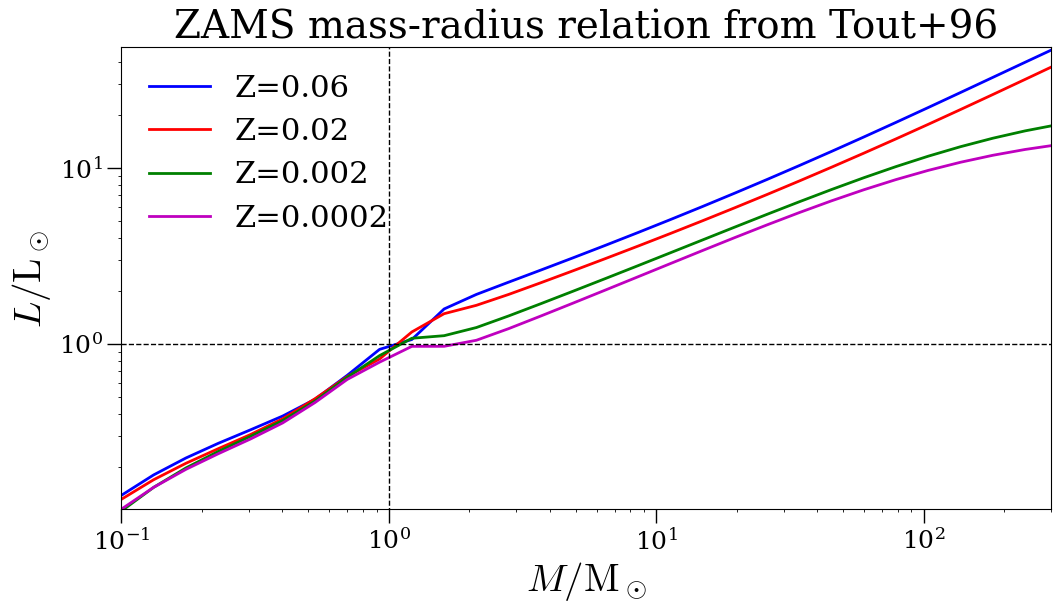

In [10]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(test_masses, test_radii_z006, 'b', label='Z=0.06')
ax.plot(test_masses, test_radii_z002, 'r', label='Z=0.02')
ax.plot(test_masses, test_radii_z0002, 'g', label='Z=0.002')
ax.plot(test_masses, test_radii_z00002, 'm', label='Z=0.0002')
ax.set_xscale('log')
ax.set_yscale('log')
ax.vlines(1, 0.1, 100, color='k', ls='--', lw=1)
ax.hlines(1, 0.1, 300, color='k', ls='--', lw=1)
ax.set_ylim(min(test_radii_z00002), max(test_radii_z006))
ax.set_xlim(0.1, 300)

ax.legend(frameon=False)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$L/\\mathrm{L}_\\odot$')

ax.set_title('ZAMS mass-radius relation from Tout+96')

For the MLR,

$$
R(M,Z) = \frac  {\alpha M^{5.5} + \beta M^{11}}
                {\gamma + M^3 + \delta M^5 + \epsilon M^7 + \zeta M^8 + \eta M^{9.5}},
$$

where each parameter given as before, as

$$\theta = a + b\log Z/\mathrm{Z}_\odot + c \log^2 Z/\mathrm{Z}_\odot + d \log^3 Z/\mathrm{Z}_\odot + e \log^4 Z/\mathrm{Z}_\odot,$$

The table with all coefficients is stored in ```tout_zams_mlr```. The class below loads it, computes the  coefficients for a given metallicity, and allows getting the radius for any mass.

In [11]:
class ToutMassLuminosityRelation:
    """Mass-radius relation at ZAMS from Tout et al. (1996)."""

    def __init__(self, metallicity=Z_SUN):
        self.metallicity = metallicity
        self.fit_params = None
        self.coefficients = None
        self._load_fit_params()
        self._set_coefficients()

    def _load_fit_params(self):
        self.fit_params = np.genfromtxt('tout_zams_mlr', skip_header=True, usecols=(1, 2, 3, 4, 5))
    
    def _set_coefficients(self):
        met_factor = np.array([np.log10(self.metallicity/Z_SUN)**i for i in range(5)])
        met_factor = np.tile(met_factor, (8, 1))
        met_factor[-2] = np.ones(5)/5
        self.coefficients = self.fit_params * met_factor
        self.coefficients = np.sum(self.coefficients, axis=1)

    def luminosity(self, m):
        m = fix_unit(m, MASS_U).to(u.Msun).value
        indices = np.array([5.5, 11, 0, 3, 5, 7, 8, 9.5])
        terms = self.coefficients * m**indices
        luminosity = np.sum(terms[:2]) / np.sum(terms[2:])
        return luminosity * u.Lsun
        

In [12]:
test_masses = np.logspace(-1, 2.5, 30)

mlr_z006 = ToutMassLuminosityRelation(metallicity=0.06)
test_luminosities_z006 = np.array([mlr_z006.luminosity(m).value for m in test_masses])

mlr_z002 = ToutMassLuminosityRelation(metallicity=0.02)
test_luminosities_z002 = np.array([mlr_z002.luminosity(m).value for m in test_masses])

mlr_z0002 = ToutMassLuminosityRelation(metallicity=0.002)
test_luminosities_z0002 = np.array([mlr_z0002.luminosity(m).value for m in test_masses])

mlr_z00002 = ToutMassLuminosityRelation(metallicity=0.0003)
test_luminosities_z00002 = np.array([mlr_z00002.luminosity(m).value for m in test_masses])

Text(0.5, 1.0, 'ZAMS mass-luminosity relation from Tout+96')

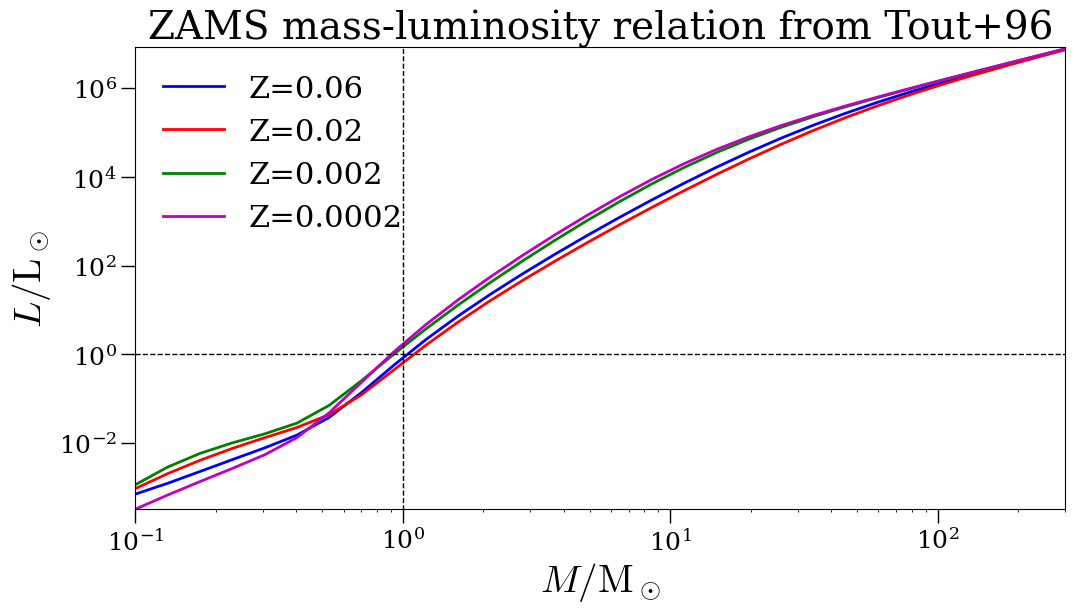

In [13]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(test_masses, test_luminosities_z006, 'b', label='Z=0.06')
ax.plot(test_masses, test_luminosities_z002, 'r', label='Z=0.02')
ax.plot(test_masses, test_luminosities_z0002, 'g', label='Z=0.002')
ax.plot(test_masses, test_luminosities_z00002, 'm', label='Z=0.0002')
ax.set_xscale('log')
ax.set_yscale('log')
ax.vlines(1, 1e-4, 1e7, color='k', ls='--', lw=1)
ax.hlines(1, 0.1, 300, color='k', ls='--', lw=1)
ax.set_ylim(min(test_luminosities_z00002), max(test_luminosities_z00002))
ax.set_xlim(0.1, 300)

ax.legend(frameon=False)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$L/\\mathrm{L}_\\odot$')

ax.set_title('ZAMS mass-luminosity relation from Tout+96')

For naked He stars, the relations are different. Taken from Hurley et al. (2000), for the zero-age radius at solar metallicity, we have

$$
R_\mathrm{He}^\mathrm{ZA} = \frac{0.2391M^{4.6}}{M^4+0.162M^3+0.0065}.
$$

In [14]:
def tau_he_ms(m):
    m = fix_unit(m, MASS_U).to(MASS_U).value
    coefficients = np.array([0.4129, 18.81, 1.853, 1]) 
    indices = np.array([0, 4, 6, 6.5])
    terms = coefficients * m**indices
    return np.sum(terms[:3]) / np.sum(terms[3:]) * u.Myr

In [15]:
class HurleyMassRadiusRelation:

    def __init__(self, metallicity=Z_SUN):
        self.metallicity = metallicity

    def _beta(self, m):
        m = fix_unit(m, MASS_U).value
        return max(0, 0.4 - 0.22 * np.log10(m))

    def zams_radius(self, m):
        m = fix_unit(m, MASS_U).to(MASS_U).value
        coefficients = np.array([0.2391, 1, 0.162, 0.0065])
        indices = np.array([4.6, 4, 3, 0])
        terms = coefficients * m**indices
        zams_radius = np.sum(terms[:1]) / np.sum(terms[1:])
        return zams_radius * u.Rsun

    def radius(self, m, t=0):
        m = fix_unit(m, MASS_U)
        t = fix_unit(t, AGE_U)
        tau = (t/tau_he_ms(m)).value
        beta = self._beta(m)
        r_zams = self.zams_radius(m)
        return (1 + beta*tau - beta*tau**6) * r_zams

And for luminosity at solar metallicity,

$$
L_\mathrm{He}^\mathrm{ZA} = \frac{16,262M^{10.25}}{M^9 + 29.54 M^{7.5} + 31.18 M^6 + 0.0469}.
$$

In [16]:
class HurleyMassLuminosityRelation:

    def __init__(self, metallicity=Z_SUN):
        self.metallicity = metallicity

    def _alpha(self, m):
        m = fix_unit(m, MASS_U).value
        return max(0, 0.85 - 0.08 * m)

    def zams_luminosity(self, m):
        m = fix_unit(m, MASS_U).to(MASS_U).value
        coefficients = np.array([15262, 1, 29.54, 31.18, 0.0469])
        indices = np.array([10.25, 9, 7.5, 6, 0])
        terms = coefficients * m**indices
        zams_luminosity = np.sum(terms[:1]) / np.sum(terms[1:])
        return zams_luminosity * u.Lsun

    def luminosity(self, m, t=0):
        m = fix_unit(m, MASS_U)
        t = fix_unit(t, AGE_U)
        tau = (t/tau_he_ms(m)).value
        alpha = self._alpha(m)
        l_zams = self.zams_luminosity(m)
        return (1 + 0.45*tau + alpha*tau**2) * l_zams

Here we may note a first concern about applying wind models based on WR or naked He stars to hydrogen-poor MS stars: the former are much brighter and more compact than the former, which means that the same mass-dependent prescription will lead to much greater mass loss rates for MS stars then for WR/He stars. We compare the Tout+96 MLR and MRR for (zero age-) HMS stars and the Hurley+2000 MLR and MRR for (zero age-) HeMS stars below.

In [17]:
test_masses = np.logspace(0, 2.5, 30)
test_z = Z_SUN

tout_test_mrr = ToutMassRadiusRelation(test_z)
tout_test_radii = np.array([tout_test_mrr.radius(m).value for m in test_masses])

hurley_he_test_mrr = HurleyMassRadiusRelation(test_z)
hurley_he_test_radii = np.array([hurley_he_test_mrr.radius(m).value for m in test_masses])

In [18]:
tout_test_mlr = ToutMassLuminosityRelation(test_z)
tout_test_luminosities = np.array([tout_test_mlr.luminosity(m).value for m in test_masses])

hurley_he_test_mlr = HurleyMassLuminosityRelation(test_z)
hurley_he_test_luminosities = np.array([hurley_he_test_mlr.luminosity(m).value for m in test_masses])

(0.0, 40.84761123717147)

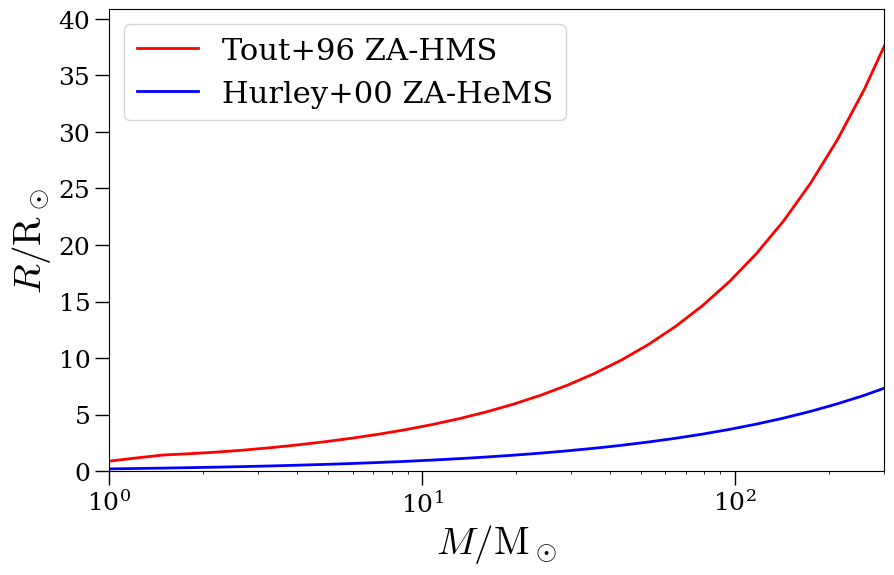

In [19]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(test_masses, tout_test_radii, 'r-', label='Tout+96 ZA-HMS ')
ax.plot(test_masses, hurley_he_test_radii, 'b-', label='Hurley+00 ZA-HeMS')
ax.set_xscale('log')
ax.legend()

ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')
ax.set_xlim(1, 300)
ax.set_ylim(0)

/tmp/ipykernel_1385995/3648833286.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0)


(0.2727346806294649, 47987251.91166866)

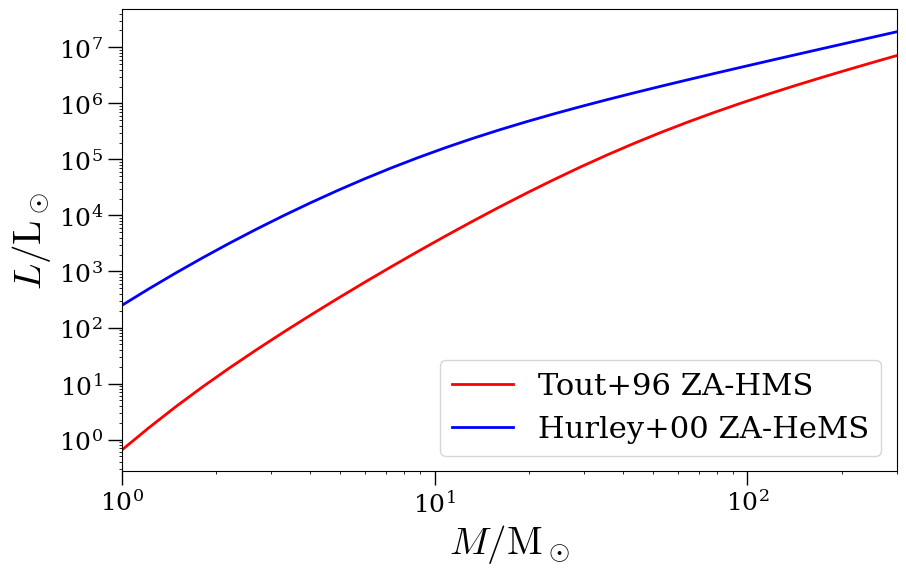

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(test_masses, tout_test_luminosities, 'r-', label='Tout+96 ZA-HMS ')
ax.plot(test_masses, hurley_he_test_luminosities, 'b-', label='Hurley+00 ZA-HeMS')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$L/\\mathrm{L}_\\odot$')
ax.set_xlim(1, 300)
ax.set_ylim(0)

Finally, we define functions for the surface gravity,

$$\log g = \log \left( \frac{1}{\mathrm{cm}\,\mathrm{s}^{-1}} \frac{GM}{R^2} \right),$$

In [21]:
def log_g(m, r, metallicity=Z_SUN):
    m = fix_unit(m, MASS_U)
    r = fix_unit(r, RADIUS_U)
    g = (ct.G * m / r**2).to(u.cm / u.s**2)
    log_g = np.log10(g.value)
    return log_g


and the effective temperature,

$$T_\mathrm{eff} = \left(\frac{1}{4\pi\sigma_\mathrm{SB}} \frac{L}{R^2} \right)^{\frac{1}{4}},$$

In [22]:
def t_eff(l, r, metallicity=Z_SUN):
    l = fix_unit(l, LUMINOSITY_U)
    r = fix_unit(r, RADIUS_U)
    t_eff = l / (4*np.pi*r**2 * ct.sigma_sb)
    t_eff = t_eff**(1/4)
    return t_eff.to(TEMP_U)

Putting the HMS and HeMS on the HR diagram again illustrate that He stars are much brighter and more compact than MS stars.

In [23]:
hurley_he_test_teff = np.array([t_eff(l, r).to(u.K).value for l, r in zip(hurley_he_test_luminosities, hurley_he_test_radii)])
tout_test_teff = np.array([t_eff(l, r).to(u.K).value for l, r in zip(tout_test_luminosities, tout_test_radii)])

hurley_he_test_logg = np.array([log_g(m, r) for m, r in zip(test_masses, hurley_he_test_radii)])
tout_test_logg = np.array([log_g(m, r) for m, r in zip(test_masses, tout_test_radii)])

Text(0.5, 0, '$T_\\mathrm{eff}/\\mathrm{K}$')

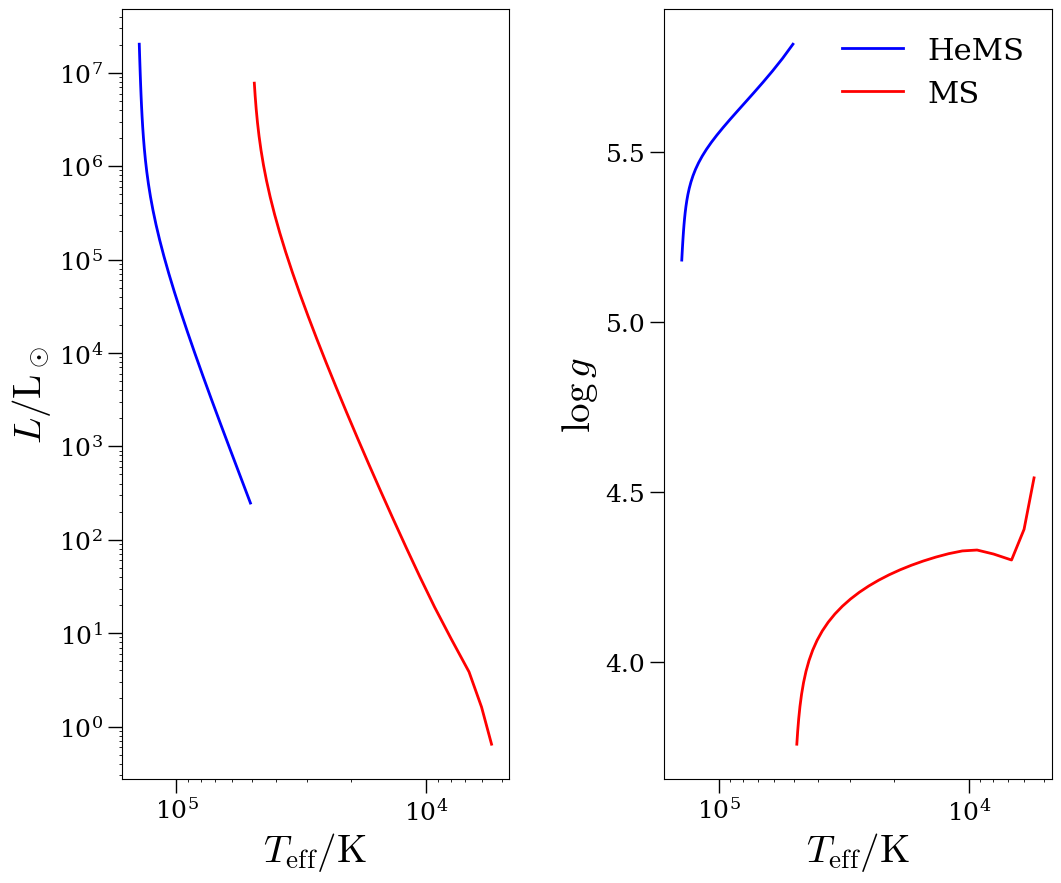

In [24]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(12,10))
fig.subplots_adjust(wspace=0.4)

ax0.plot(hurley_he_test_teff, hurley_he_test_luminosities, 'b-', label='HeMS')
ax0.plot(tout_test_teff, tout_test_luminosities, 'r-', label='MS')
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.invert_xaxis()
ax0.set_xlabel('$T_\\mathrm{eff}/\\mathrm{K}$')
ax0.set_ylabel('$L/\\mathrm{L}_\\odot$')

ax1.plot(hurley_he_test_teff, hurley_he_test_logg, 'b-', label='HeMS')
ax1.plot(tout_test_teff, tout_test_logg, 'r-', label='MS')
ax1.set_xscale('log')
ax1.invert_xaxis()
ax1.legend(frameon=False)
ax1.set_ylabel('$\\log g$')
ax1.set_xlabel('$T_\\mathrm{eff}/\\mathrm{K}$')

Lastly, we also want to confirm that none of the systems are in such tight orbits that the primary reaches critical rotation, at a period,

$$P_\mathrm{K} = \left(  \frac{2\pi^2 R^3}{GM} \right)^{\frac{1}{2}}.$$

In [25]:
def P_k(m, r):
    m = fix_unit(m, MASS_U)
    r = fix_unit(r, RADIUS_U)
    return np.sqrt(2 * np.pi**2 * r**3 / (ct.G * m))

### Binary geometry

Next, we define the Roche lobe-equivalent radii, and the L2-equivalent radius.

For the Roche lobe, we adopt the approximation by Eggleton (1983) for the primary Roche lobe-equivalent radius,

$$
R_\mathrm{RL,1} = \frac{0.49 q^{2/3}}{0.6 q^{2/3} + \ln (1+q^{1/3})} A.
$$

Which is implemented in the two functions below for the primary and secondary Roche lobe radii ($R_\mathrm{RL,2}$).

In [26]:
def eggleton_rl1_radius(a, q):
    a = fix_unit(a, SMA_U)
    rl1 = 0.49 * q**(2/3) / (0.6*q**(2/3) + np.log(1 + q**(1/3))) * a
    rl1 = rl1.to(RADIUS_U)
    return rl1    

In [27]:
def eggleton_rl2_radius(a, q):
    a = fix_unit(a, SMA_U)
    Q = 1/q
    rl2 = 0.49 * Q**(2/3) / (0.6*Q**(2/3) + np.log(1 + Q**(1/3))) * a
    rl2 = rl2.to(RADIUS_U)
    return rl2    

For the L2-equivalent radius ($R_\mathrm{L2,2}$), we adopt the fit from Marchant et al. (2016) (equation 2 therein),

$$\frac{R_{L2,2}-R_\mathrm{RL,2}}{R_\mathrm{RL,2}} = 0.299 \arctan \left( 1.84 q^{0.397} \right),$$

which was found to be satisfied in their simulations with an error smaller than 2% within $0.02\leq q\leq1$. This fit is implemented in the function below.

In [28]:
def marchant_l2_radius(a, q):
    a = fix_unit(a, SMA_U)
    rl2 = eggleton_rl2_radius(a, q)
    relative_l2_radius = 0.299 * np.arctan(1.84 * q**0.397)
    l2_radius = (1 + relative_l2_radius) * rl2
    return l2_radius

In [29]:
min_m = 10
max_m = 300
res = 30
test_masses = np.logspace(np.log10(min_m), np.log10(max_m), res)

test_qs = np.array([1, 0.9, 0.8])
test_ps = np.array([1, 2, 3, 4]) * u.d

r_rl1_arr = np.zeros((test_qs.shape[0], test_ps.shape[0], test_masses.shape[0]))
r_rl2_arr = np.zeros((test_qs.shape[0], test_ps.shape[0], test_masses.shape[0]))
r_l2_arr = np.zeros((test_qs.shape[0], test_ps.shape[0], test_masses.shape[0]))

for row, q in enumerate(test_qs):
    for col, p in enumerate(test_ps):
        r_rl1_arr[row, col] = np.array([eggleton_rl1_radius(a_from_p(p, m, q), q).to(u.Rsun).value for m in test_masses])
        r_rl2_arr[row, col] = np.array([eggleton_rl2_radius(a_from_p(p, m, q), q).to(u.Rsun).value for m in test_masses])
        r_l2_arr[row, col] = np.array([marchant_l2_radius(a_from_p(p, m, q), q).to(u.Rsun).value for m in test_masses])


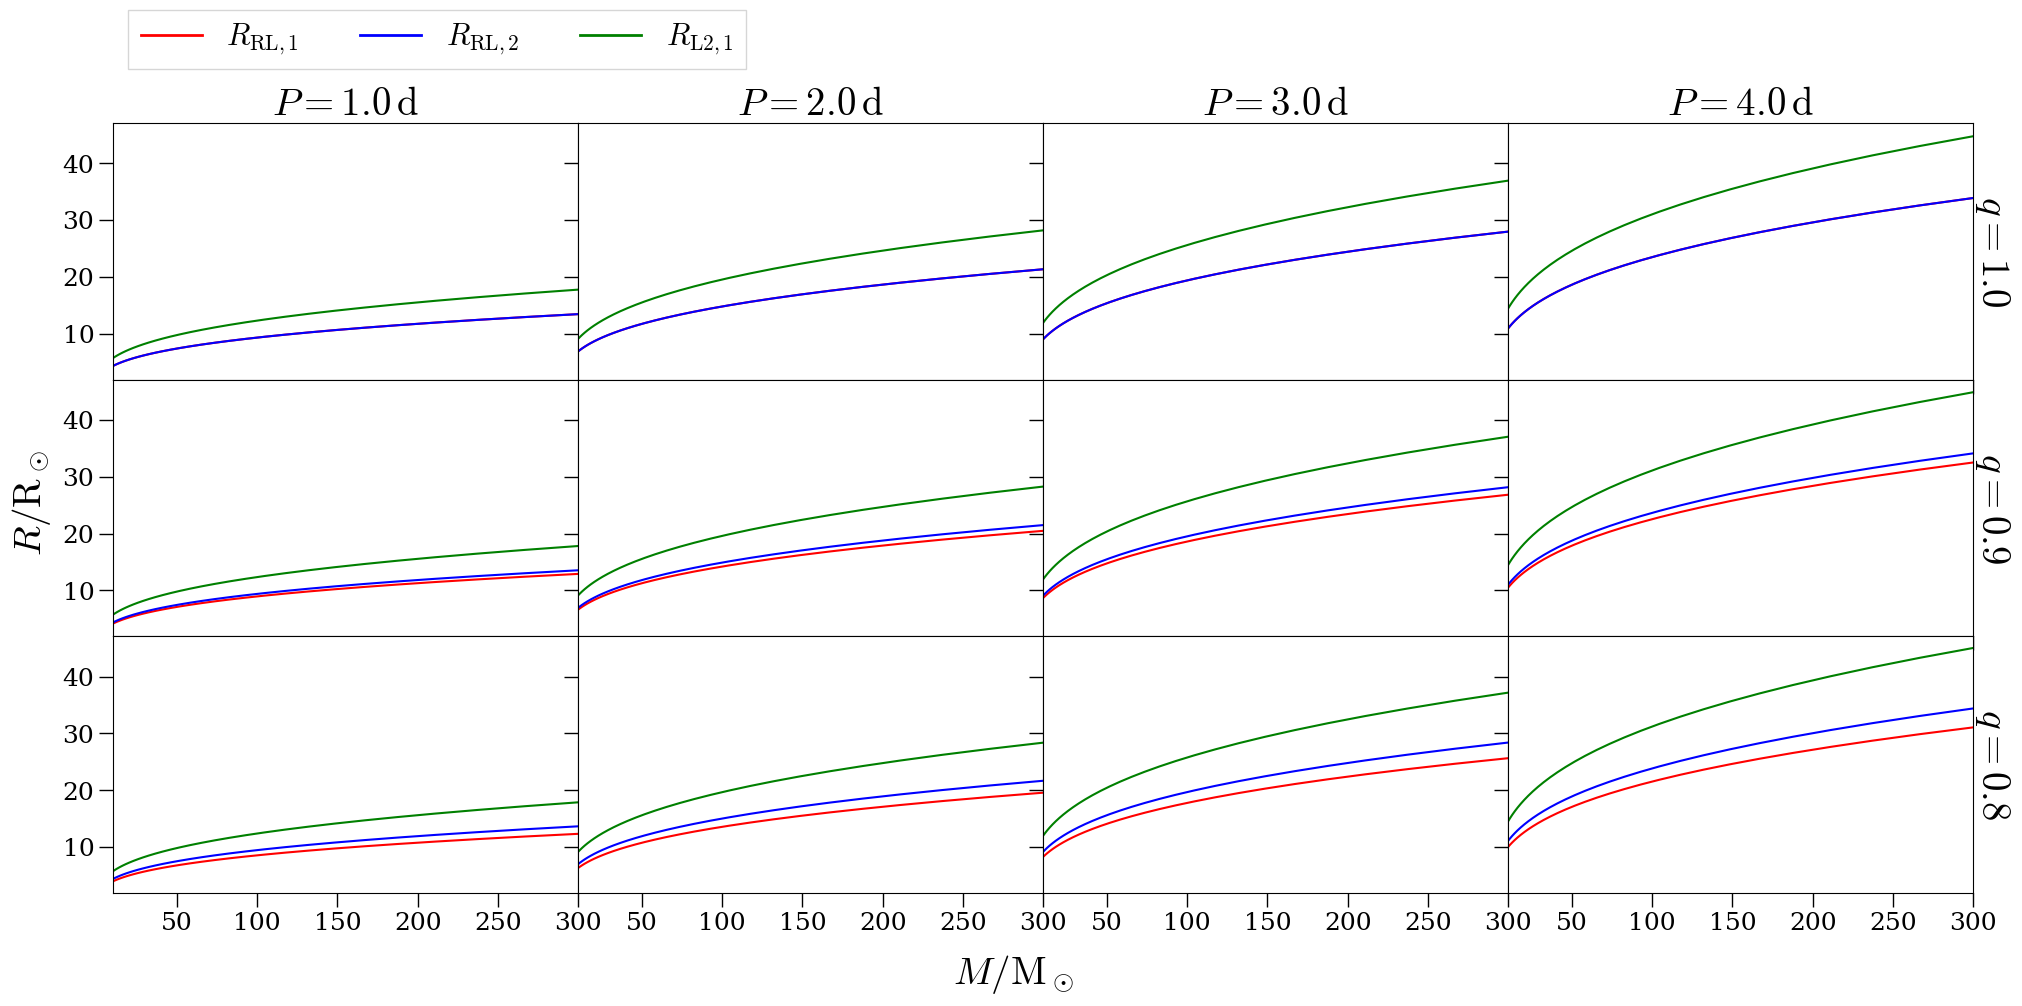

In [30]:
lw = 1.5

fig, axes = plt.subplots(len(test_qs), len(test_ps), figsize=(24, 10), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for row, (ax_row, q) in enumerate(zip(axes, test_qs)):
    for col, (ax, p) in enumerate(zip(ax_row, test_ps)):
        ax.plot(test_masses, r_rl1_arr[row, col], 'r-', lw=lw)
        ax.plot(test_masses, r_rl2_arr[row, col], 'b-', lw=lw)
        ax.plot(test_masses, r_l2_arr[row, col], 'g-', lw=lw)

# LIMITS
axes[0, 0].set_xlim(min_m, max_m)

# LABELS
fig.text(0.5, 0.05, r'$M/\mathrm{M}_\odot$', ha='center', va='top', transform=fig.transFigure)
fig.text(0.1, 0.5, r'$R/\mathrm{R}_\odot$', rotation=90, ha='right', va='center', transform=fig.transFigure)

for ax, q in zip(axes[:,-1], test_qs):
    ax.text(1, 0.5, f'$q={q:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)

for ax, p in zip(axes[0,:], test_ps):
    ax.text(0.5, 1, f'$P={p.value:.1f}\\,\\mathrm{{d}}$', ha='center', va='bottom', transform=ax.transAxes)

handles = []
handles.append(Line2D((0, 0), (0, 0), color='r', ls='-', label=r'$R_\mathrm{RL,1}$'))
handles.append(Line2D((0, 0), (0, 0), color='b', ls='-', label=r'$R_\mathrm{RL,2}$'))
handles.append(Line2D((0, 0), (0, 0), color='g', ls='-', label=r'$R_\mathrm{L2,1}$'))
axes[0, 0].legend(handles=handles, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1.15), ncol=3)

### Timescales

Next we define the relevant timescales for BBH merger formation through CHE.

We take the hydrogen fraction (for the MS timescale) from a linear fit between Big Bang mass fractions (X=0.75, Y=0.05, Z=0) and solar (X=0.7, Y=0.28, Z=0.02).

In [31]:
# TODO: check this assumption
def get_x_y(z):
    x = 0.75 - 5/2 * z
    y = 1 - x - z
    return x, y 

We make a simple estimate of the MS timescale from the luminosity and the amount of hydrogen available in the core at ZAMS,

$$\tau_\mathrm{MS} \approx f_\mathrm{core} X \Delta_{\mathrm{4H}\to\mathrm{He4}}\frac{Mc^2}{L}\approx4.9\times10^{-5}\frac{Mc^2}{L},$$

where we take $f_\mathrm{core}=0.1$ as the fraction of mass in the core, $X$ is the hydrogen mass fraction and $\Delta_{\mathrm{4H}\to\mathrm{He4}}\approx0.007$ is the mass defect of $\mathrm{He}_4$ (i.e., ignore neutrino losses). The function below computes $\tau_\mathrm{MS}$.

In [32]:
def tau_ms(m, metallicity=Z_SUN):
    m = fix_unit(m, MASS_U)
    mlr = ToutMassLuminosityRelation(metallicity)
    l = mlr.luminosity(m)
    x, _ = get_x_y(metallicity)
    f_core = 0.1
    delta_4h_he4 = 0.007
    t_ms = f_core * x * delta_4h_he4 * m * ct.c**2 / l
    return t_ms.to(AGE_U)

The function below computes the thermal timescale, $\tau_\mathrm{KH}$.

In [33]:
def tau_kh(m, metallicity=Z_SUN):
    m = fix_unit(m, MASS_U)
    mrr = ToutMassRadiusRelation(metallicity)
    r = mrr.radius(m)
    mlr = ToutMassLuminosityRelation(metallicity)
    l = mlr.luminosity(m)
    tau_kh = ct.G * m**2 / (2*r*l)   
    return tau_kh.to(AGE_U)
    

For the mixing (Eddington-Sweet) timescale, we adopt equation 11.79 from Maeder (2009),

$$t_\mathrm{ES}\approx t_\mathrm{KH} \frac{GM}{\Omega^2 R^3},$$

used in the function below, for arbitrary $\Omega$.

In [34]:
def tau_es(m, r, omega, metallicity=Z_SUN):
    m = fix_unit(m, MASS_U)
    r = fix_unit(r, RADIUS_U)
    _tau_kh = tau_kh(m, metallicity)
    tau_es = _tau_kh * ct.G * m / (omega**2 * r**3)   
    return tau_es.to(AGE_U)
    

For the tidal synchronization timescale, we look at the two energy dissipation mechanisms discussed in de Mink et al. (2009): turbulent viscosity and radiative damping. The latter has been proposed to dominate in early-type stars with radiative envelopes, but fast rotation induces turbulence even in these cases, which could make the first timescale applicable.

For turbulent viscosity synchronization, the timescale is

$$\tau_\mathrm{sync}^\mathrm{turb} = f_\mathrm{turb}q^{-2}\left(\frac{R}{A}\right)^{-6}\,\mathrm{yr},$$

where we take $f_\mathrm{turb}\approx1$. This is implemented in the function below.

In [35]:
def tau_sync_turb(m, r, p, q, metallicity=Z_SUN, f_turb=1):
    m = fix_unit(m, MASS_U)
    r = fix_unit(r, RADIUS_U)
    p = fix_unit(p, PERIOD_U)
    a = a_from_p(p, m, q)
    tau_turb = f_turb * q**-2 * (r/a)**-6 * u.yr
    return tau_turb.to(AGE_U)

For radiative damping synchronization, the timescale is

$$
\begin{align}
\tau_\mathrm{sync}^\mathrm{rad} &= f_\mathrm{rad}q^{-2}(1+q)^{-5/6} \left( \frac{R}{A} \right)^{-17/2}\,\mathrm{yr}, \\
\text{where } f_\mathrm{rad} &= 52^{-5/3}E_2\frac{I}{MR^2} \left( \frac{GM}{R^3} \right)^{-1/2},
\end{align}
$$

with $E_2\propto(R_\mathrm{core}/R)^8$ the tidal coefficient. This is (not yet) implemented in the function below,

In [36]:
def t_sync_rad(m, r, p, q, metallicity=Z_SUN):
    """PLACEHOLDER"""
    return

We define the *mixing* timescale as the sum of the Eddington-Sweet timescale and either the turbulent or radiative synchronization timescale. This should represent the maximum time a star will take to spin up to the orbital period and become thoroughly mixed.

In [37]:
def tau_mix(m, r, p, q, metallicity=Z_SUN, mode='turbulent'):
    m = fix_unit(m, MASS_U)
    p = fix_unit(p, PERIOD_U)
    r = fix_unit(r, RADIUS_U)

    if mode == 'turbulent':
        tau_sync = tau_sync_turb(m, r, p, q, metallicity=metallicity)
    elif mode == 'radiative':
        tau_sync = tau_sync_rad(m, r, p, q, metallicity=metallicity)
    else:
        raise ValueError(f'Mode should be either "turbulent" or "radiative", not "{mode}".')
    
    taues = tau_es(m, r, 2*np.pi/p, metallicity=metallicity)

    taumix = (taues + tau_sync).to(AGE_U)
    return taumix

The gravitational decay timescale, assuming a circular orbit, is

$$\tau_\mathrm{GW} = \frac{5}{256} \frac{c^5}{G^3} \frac{A}{(1+q)qM},$$

which is implemented in the function below.

In [38]:
def tau_gw(m, p, q):
    m = fix_unit(m, MASS_U)
    p = fix_unit(p, PERIOD_U)
    a = a_from_p(p, m, q)

    _c = 5 * ct.c**5 / 256 / ct.G**3
    tgw = _c * a**4 / (m**3 * q *(1+q))
    return tgw.to(AGE_U)

We apply $\tau_\mathrm{GW}$ at ZAMS. Because the stars will lose mass and the orbit will widen, $\tau_\mathrm{GW}$ at ZAMS can be used as the *shortest* timescale on which the binary will merge.

Text(0.5, 1.0, 'P=4.0 d, q=1, Z=1.00 $Z_\\odot$')

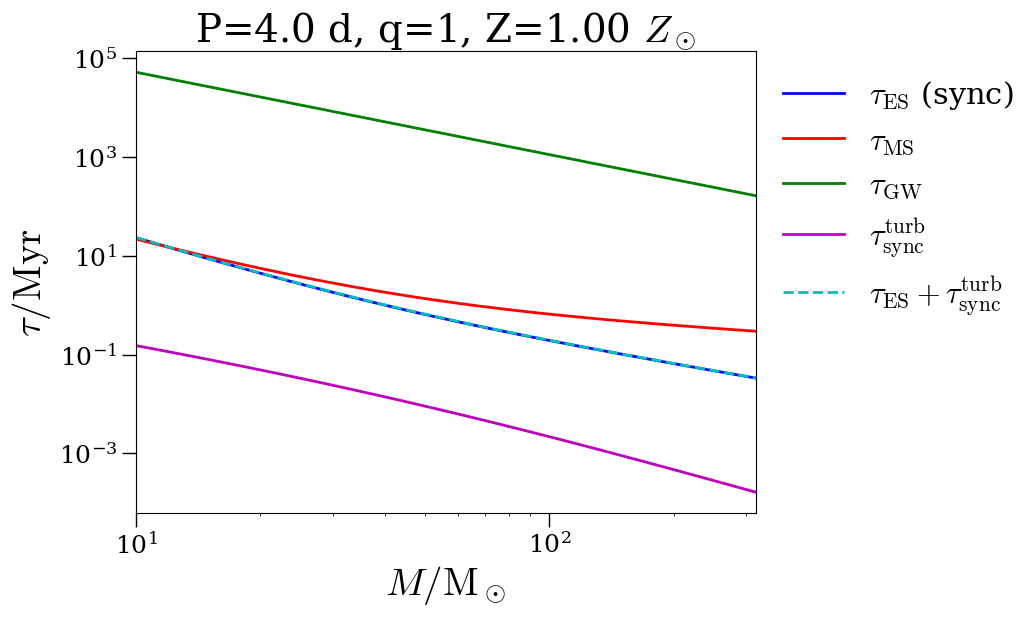

In [39]:
test_p = 4*u.d
test_omega = 2*np.pi/test_p
test_q = 1
test_z = Z_SUN

mrr = ToutMassRadiusRelation(metallicity=test_z)

test_masses = np.logspace(1, 2.5, 30)
test_radii = np.array([mrr.radius(m).value for m in test_masses])

test_tau_es = np.array([tau_es(m, r, test_omega, metallicity=test_z).to(u.Myr).value for m, r in zip(test_masses, test_radii)])
test_tau_sync_turb = np.array([tau_sync_turb(m, r, test_p, test_q, metallicity=test_z).to(u.Myr).value for m, r in zip(test_masses, test_radii)])
test_tau_ms = np.array([tau_ms(m, metallicity=test_z).to(u.Myr).value for m in test_masses])
test_tau_gw = np.array([tau_gw(m, test_p, test_q).to(u.Myr).value for m in test_masses])

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(test_masses, test_tau_es, 'b', label=r'$\tau_\mathrm{ES}$ (sync)')
ax.plot(test_masses, test_tau_ms, 'r', label=r'$\tau_\mathrm{MS}$')
ax.plot(test_masses, test_tau_gw, 'g', label=r'$\tau_\mathrm{GW}$')
ax.plot(test_masses, test_tau_sync_turb, 'm', label=r'$\tau_\mathrm{sync}^\mathrm{turb}$')
ax.plot(test_masses, test_tau_es+test_tau_sync_turb, '--', c='c', label=r'$\tau_\mathrm{ES}+\tau_\mathrm{sync}^\mathrm{turb}$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$\tau/\mathrm{Myr}$')
ax.set_xlabel(r'$M/\mathrm{M}_\odot$')
ax.set_xlim(10, 10**2.5)
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
ax.set_title(f'P={test_p}, q={test_q}, Z={test_z/Z_SUN:.2f} $Z_\\odot$')

### Wind mass loss

For wind mass loss rates in MS stars, we adopt the thin wind prescription by Gormaz-Matamala et al. (2022), which was implemented in Romagnolo, Gormaz-Matamal & Belczynski (2024) for $T_\mathrm{eff}\geq10\,\mathrm{kK}$ and $\log g \geq3$ stars with thin winds.

In this prescription the mass loss rate is

$$
\begin{align}
\log\dot{M} = &-40.314 + 15.438w + 45.838x - 8.284wx \\
              &+1.0564y - wy/2.36 - 1.1967xy \\
              &+ z \left( 1 + \frac{15.75}{M/\mathrm{M}_\odot} \right),
\end{align}
$$

where   

$$
\begin{align}
w = &\log\frac{T_\mathrm{eff}}{\mathrm{kK}}, \qquad
x = &\frac{1}{\log g}, \qquad
y = &\frac{R}{\mathrm{R}_\odot}, \qquad
z = &\frac{Z}{\mathrm{Z}_\odot}.
\end{align}
$$

The prescription is implemented in the class below, which also implements a spline to speed up calculation.

In [40]:
class GormazMatamalaWinds:

    def __init__(self, metallicity=Z_SUN, m_min=10, m_max=300):
        self.metallicity = metallicity
        self.m_min = m_min
        self.m_max = m_max
        self.mlr = ToutMassLuminosityRelation(metallicity)
        self.mrr = ToutMassRadiusRelation(metallicity)
        self.spline = None
        self._set_spline()

    def _set_spline(self):
        masses = np.logspace(np.log10(self.m_min), np.log10(self.m_max), 30)
        logmdots = np.array([self.log_mass_loss_rate(m) for m in masses])
        self.spline = CubicSpline(masses, logmdots)        

    def log_mass_loss_rate(self, m):
        m = fix_unit(m, MASS_U).to(u.Msun).value
        l = self.mlr.luminosity(m)
        r = self.mrr.radius(m)
        teff = t_eff(l, r, self.metallicity)
        logg = log_g(m, r, self.metallicity)
        
        w = np.log10(teff.to(u.kK).value)
        x = 1/logg
        y = r.to(u.Rsun).value
        z = np.log10(self.metallicity/Z_SUN)

        log_mdot = (-40.314 + 15.438*w + 45.838*x - 8.284*w*x
                    + 1.0564*y - w*y/2.36 - 1.1967*x*y
                    + z * (0.4 + 15.75/m))
        
        return log_mdot

In [41]:
winds = GormazMatamalaWinds()

In [42]:
test_masses = np.logspace(1, 2.5, 30)
test_logmdots = np.array([winds.log_mass_loss_rate(m) for m in test_masses])
test_spline_logmdots = np.array([winds.spline(m) for m in test_masses])

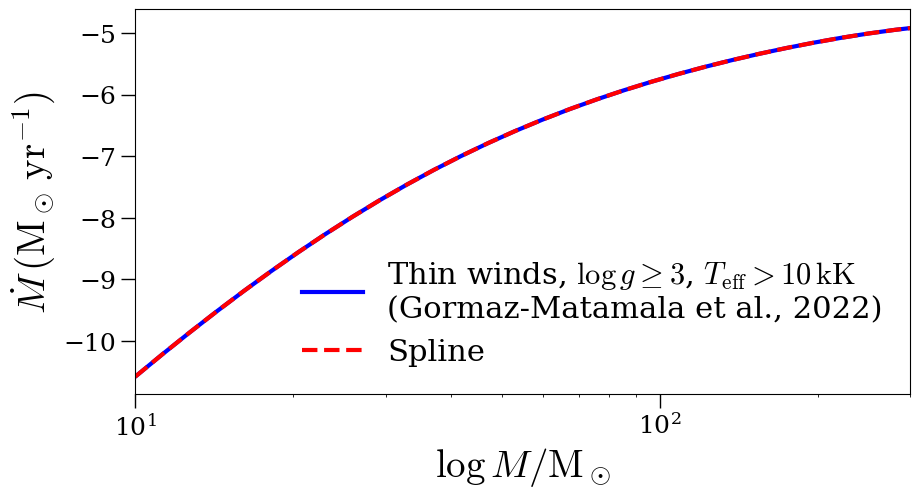

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(test_masses, test_logmdots, 'b-', lw=3, label='Thin winds, $\\log g\\geq3$, $T_\\mathrm{eff}>10\\,\\mathrm{kK}$ \n(Gormaz-Matamala et al., 2022)')
plt.plot(test_masses, test_spline_logmdots, 'r--', lw=3, label='Spline')
plt.xscale('log')
plt.xlim(10, 300)
plt.xlabel('$\\log M/\\mathrm{M}_\\odot$')
plt.ylabel('$\\dot{M}\\,(\\mathrm{M}_\\odot\,\\mathrm{yr}^{-1})$')
plt.legend(frameon=False)

The surface of CHE stars, however, becomes hydrogen-poor during the MS, and thus they can be expected to suffer from enhanced winds, equal or similar to the winds of WR or binary-stripped He stars. For this mass loss regime, we adopt the prescription from Vink & Sander (2020),

$$\dot{M}_\mathrm{VS20} = \dot{M}_{10} \left( \log\frac{L}{L_0} \right)^\alpha \left( \frac{L}{10L_0} \right)^{\frac{3}{4}},$$

where $L_0$ is the "asymptotic limit" for which there would theoretically be zero mass loss; $\dot{M}_{10}:=\dot{M}_\mathrm{VS20}(L=L_0)$; and $\alpha$ describes the curvature of $\dot{M}_\mathrm{VS20}(L)$ around the breakdown of the WR-wind regime, as winds transition to being optically thin. These parameters are given as a function of metallicity, as

$$
\begin{align}
&\alpha = 0.32\log\frac{Z}{\mathrm{Z}_\odot} + 1.4, \\
&\log\frac{L}{\mathrm{L}_\odot} = -0.87\log\frac{Z}{\mathrm{Z}_\odot} + 5.06, \\
&\log\frac{\dot{M}_{10}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = -0.95\log\frac{Z}{\mathrm{Z}_\odot} - 4.06.
\end{align}
$$

Additionally, for $T_\mathrm{eff}>100\,\mathrm{kK}$, we apply the temperature correction from Sanders et al. (2023),

$$
\begin{align}
\log \frac{\dot{M}_\mathrm{S23}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = \log\frac{\dot{M}_\mathrm{VS20}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} - 6\log\frac{T_\mathrm{eff}}{141\,\mathrm{kK}}.
\end{align}
$$

In [44]:
class VinkSanderWinds:

    def __init__(self, mlr, mrr, metallicity=Z_SUN):
        self.mlr = mlr
        self.mrr = mrr
        self.metallicity = metallicity
        self.alpha = metallicity
        self.luminosity0 = metallicity
        self.dot_m10 = metallicity

    @property
    def alpha(self):
        return self._alpha
    
    @alpha.setter
    def alpha(self, metallicity):
        self._alpha = 0.32 * np.log10(metallicity/Z_SUN) + 1.4

    @property
    def luminosity0(self):
        return self._luminosity0
    
    @luminosity0.setter
    def luminosity0(self, metallicity):
        log_luminosity0 = -0.87 * np.log10(metallicity/Z_SUN) + 5.06
        self._luminosity0 = 10**log_luminosity0 * u.Lsun

    @property
    def dot_m10(self):
        return self._dot_m10
    
    @dot_m10.setter
    def dot_m10(self, metallicity):
        log_dot_m10 = -0.75 * np.log10(metallicity/Z_SUN) - 4.06
        self._dot_m10 = 10**log_dot_m10 * u.Msun / u.yr


    def _vs2020_winds(self, m):
        m = fix_unit(m, MASS_U)
        luminosity = self.mlr.luminosity(m)
        return self.dot_m10 * np.log10(luminosity/self.luminosity0)**self.alpha * (luminosity / (10*self.luminosity0))**(3/4)
    
    def log_mass_loss_rate(self, m):
        m = fix_unit(m, MASS_U)
        l = self.mlr.luminosity(m)
        r = self.mrr.radius(m)
        teff = t_eff(l, r, metallicity=self.metallicity)
        if l < self.luminosity0:
            log_mass_loss_rate = -20.
        elif teff > 1e5 * u.K:
            log_vs2020_rate = np.log10(self._vs2020_winds(m).to(u.Msun/u.yr).value)
            
            log_mass_loss_rate = log_vs2020_rate
        else:
            log_vs2020_rate = np.log10(self._vs2020_winds(m).to(u.Msun/u.yr).value)
            t_corr = 6 * np.log10(teff.to(u.kK).value/141)
            log_mass_loss_rate = log_vs2020_rate - t_corr
        return log_mass_loss_rate
            


We do *not* model the star's chemical evolution, nor the resulting luminosity and radius evolution. However, it is important to account for the fact that He stars, due to lowered opacity and increased mean molecular weight in the envelope, should be more compact and brighter; otherwise, as suggested, WR-winds would "blow away' the star. We can see this effect by comparing MS-wind mass loss rates to three cases of WR winds: with ZA-HMS luminosity and radius (Tout+96); with ZA-HeMS luminosity and radius (Hurley+00; and with ZA-HMS radius, but ZA-HeMS luminosity.

In [45]:
test_z = Z_SUN
test_masses = np.logspace(0, 2.5, 100)

gm22_winds = GormazMatamalaWinds(metallicity=test_z)  # MS winds
vs23_tout_winds = VinkSanderWinds(mlr=ToutMassLuminosityRelation(test_z),  # WR winds w/ HMS luminosity, radius
                                  mrr=ToutMassRadiusRelation(test_z),
                                  metallicity=test_z)
vs23_hurley_winds = VinkSanderWinds(mlr=HurleyMassLuminosityRelation(test_z),  # WR winds w/ naked HeMS luminosity, radius
                                    mrr=HurleyMassRadiusRelation(test_z),
                                    metallicity=test_z)
vs23_mixed_winds = VinkSanderWinds(mlr=HurleyMassLuminosityRelation(test_z),  # WR winds w/ naked HeMS luminosity, HMS radius 
                                   mrr=ToutMassRadiusRelation(test_z),
                                   metallicity=test_z)

def mk_test_logmdots(winds, masses):
    return np.array([winds.log_mass_loss_rate(m) for m in masses])

test_gm22_logmdots = mk_test_logmdots(gm22_winds, test_masses)
test_vs23_tout_logmdots = mk_test_logmdots(vs23_tout_winds, test_masses)
test_vs23_hurley_logmdots = mk_test_logmdots(vs23_hurley_winds, test_masses)
test_vs23_mixed_logmdots = mk_test_logmdots(vs23_mixed_winds, test_masses)


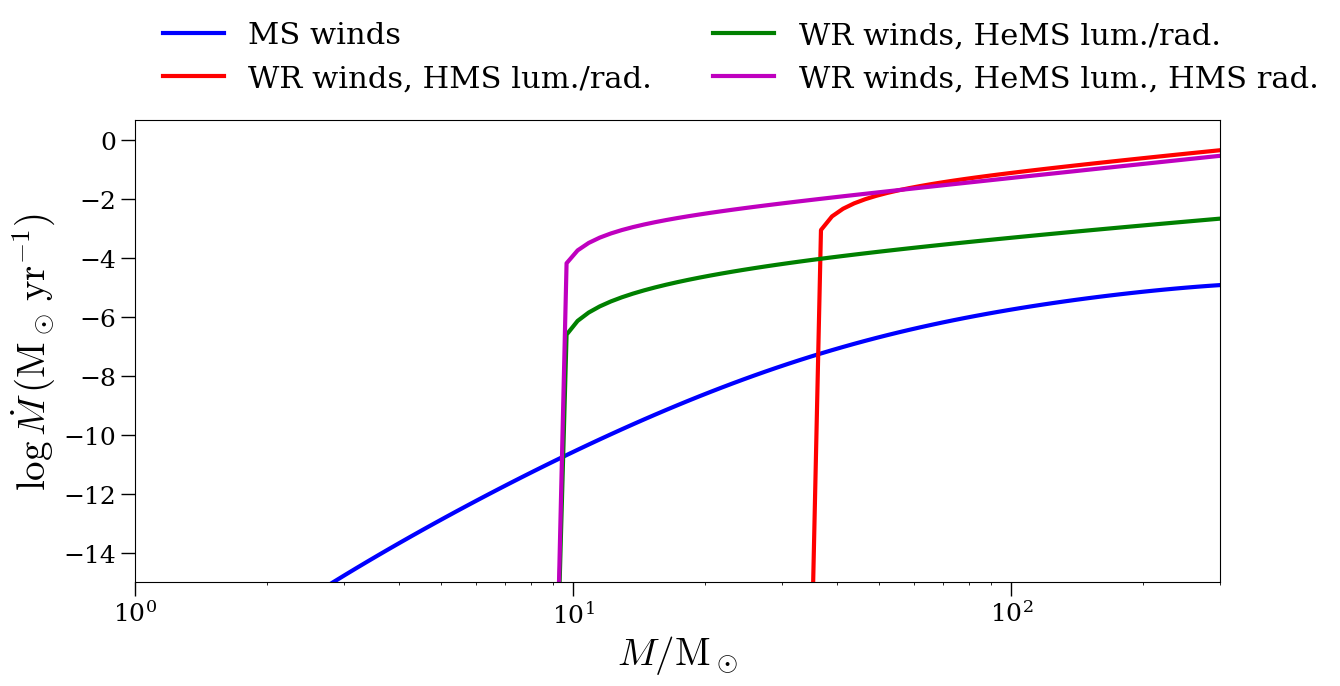

In [46]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.plot(test_masses, test_gm22_logmdots, 'b-', lw=3, label='MS winds')
plt.plot(test_masses, test_vs23_tout_logmdots, 'r-', lw=3, label='WR winds, HMS lum./rad.')
plt.plot(test_masses, test_vs23_hurley_logmdots, 'g-', lw=3, label='WR winds, HeMS lum./rad.')
plt.plot(test_masses, test_vs23_mixed_logmdots, 'm-', lw=3, label='WR winds, HeMS lum., HMS rad.')
plt.xscale('log')
plt.xlim(1, 300)
plt.ylim(-15)
plt.xlabel('$M/\\mathrm{M}_\\odot$')
plt.ylabel('$\\log\\dot{M}\\,(\\mathrm{M}_\\odot\,\\mathrm{yr}^{-1})$')
plt.legend(frameon=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=2)

We see that, if we keep HMS luminosity and masses, a massive star can lose as much as $0.01\,\mathrm{M}_\odot$ a year, until it reaches $M_0=M(L_0)\approx35\,\mathrm{M}_\odot$ (funny) and winds cease. Changing the luminosity to a HeMS prescription keeps the extreme mass loss rates, but drives the stars further down to $M_0=M(L_0)\approx9\,\mathrm{M}_\odot$. Only for both HeMS luminosity and radius do the still strong winds fall to a more manageable $10^{-6}-10^{-4}\,\mathrm{M}_\odot\,\mathrm{yr}^{-1}$.

### Orbital evolution with winds

We assume isotropic winds that carry the specific angular momentum of star (Jeans mode). In this case, semi-major axis evolution is given by

$$\frac{\mathrm{d}A}{A} = - \frac{2}{1+q} \frac{\mathrm{d}M}{M}.$$

MS winds are weak enough that it is reasonable to assume a fixed mass loss rate. Then, in Jeans mode mass loss,

$$\ln \left(
     \frac{A(t)}{A_\mathrm{ZAMS}}
     \right) = -2\ln\left(
     1 - \frac{1}{1+q_\mathrm{ZAMS}} \frac{\dot{M}}{M_\mathrm{ZAMS}}t.
     \right)$$



The same is not true for WR winds. From the Vink & Sanders prescriptions, we have, for $T_\mathrm{eff}>10^5\mathrm{K}$,

$$\frac{\mathrm{d}A}{A} = -2\left( \log\frac{L(M)}{L_0} \right)^\alpha \left( \frac{L(M)}{10L_0}\right)^{3/4} \left( \frac{T_\mathrm{eff}(M)}{141\,\mathrm{kK}} \right)^{-6} \frac{\dot{M}_{10}\mathrm{d}t}{m+M},$$

and mass loss is to intense for a fixed wind to be a reasonable assumption. We instead implement a simple integrator for wind, where the mass loss rate is fixed for each timestep $dt$; to prioritize speed, timesteps are defined so that $1\,\mathrm{M}_\odot$ within each $dt$.

The ```WindIntegrator``` class can be used with any combination of metallicity, wind, MLR and MRR models. Note, however, that the Hurley+00 HeMS fits are for solar metallicity only. The separation is simultaneously evolved assuming Jeans mode mass loss.

In [47]:
class WindIntegrator:

    def __init__(self, m0, a0, q0, wind, mlr, mrr, metallicity=Z_SUN, resolution=1):
        self.m0 = fix_unit(m0, MASS_U).to(u.Msun).value
        self.a0 = fix_unit(a0, SMA_U).to(u.Rsun).value
        self.m_comp = self.m0 * q0
        self.wind = wind
        self.mlr = mlr
        self.mrr = mrr
        self.metallicity = metallicity
        self.resolution = resolution
        self.dt = self._get_dt(m0)

    def _get_dt(self, m):
        mdot = 10.**self.wind.log_mass_loss_rate(m) * u.Msun/u.yr
        time_to_lose_res_msun = self.resolution * ct.M_sun/mdot
        return time_to_lose_res_msun.to(u.yr).value

    def _get_next_m(self, m):
        dm = 10.**self.wind.log_mass_loss_rate(m) * self.dt
        return m - dm
    
    def _get_next_a(self, a, m):
        dm = 10.**self.wind.log_mass_loss_rate(m) * self.dt
        q = self.m_comp / m
        da = - -2 / (1+q) * dm / m * a
        return a + da

    def get_m_a_at(self, t_stop):
        t_stop = fix_unit(t_stop, AGE_U).to(u.yr).value

        t = 0
        dt0 = self.dt
        m = self.m0
        a = self.a0
        while t < t_stop:
            logdmdt = self.wind.log_mass_loss_rate(m)
            if logdmdt < -10:
                break
            a = self._get_next_a(a, m)
            m = self._get_next_m(m)
            t += self.dt
            self.dt = self._get_dt(m)
        self.dt = dt0

        return m, a

Quickly testing,

In [48]:
m_test = 50
q_test = 1
p_test = 2
a_test = a_from_p(p_test, m_test, q_test)
t_stop = 1  # Myr

wi = WindIntegrator(m_test, a_test, q_test, vs23_hurley_winds, HurleyMassLuminosityRelation(Z_SUN), HurleyMassRadiusRelation(Z_SUN), Z_SUN)
m_f, a_f = wi.get_m_a_at(t_stop)
q_f = q_test * m_test / m_f
p_f = p_from_a(a_f, m_f, q_f)

print('\n'.join((f'With Hurley+00 MRR and MLR, ZAMS: m={m_test}, q={q_test}, a={a_test}, p={p_test}',
                 f'After {t_stop} Myr: m={m_f}, q={q_f}, a={a_f}, p={p_f}')))

With Hurley+00 MRR and MLR, ZAMS: m=50, q=1, a=31.00685996216504 solRad, p=2
After 1 Myr: m=12.0, q=4.166666666666667, a=79.22437284975798, p=10.373747766141921 d


Another difference in this case is that the HMS is about 10x longer than the HeMS, allowing more much greater mass loss. For reference,

In [49]:
m_test = 50
q_test = 1
p_test = 2
a_test = a_from_p(p_test, m_test, q_test)
t_stop = 0.1  # Myr

wi = WindIntegrator(m_test, a_test, q_test, vs23_hurley_winds, HurleyMassLuminosityRelation(Z_SUN), HurleyMassRadiusRelation(Z_SUN), Z_SUN)
m_f, a_f = wi.get_m_a_at(t_stop)
q_f = q_test * m_test / m_f
p_f = p_from_a(a_f, m_f, q_f)

print('\n'.join((f'With Hurley+00 MRR and MLR, ZAMS: m={m_test}, q={q_test}, a={a_test}, p={p_test}',
                 f'After {t_stop} Myr: m={m_f}, q={q_f}, a={a_f}, p={p_f}')))

With Hurley+00 MRR and MLR, ZAMS: m=50, q=1, a=31.00685996216504 solRad, p=2
After 0.1 Myr: m=37.0, q=1.3513513513513513, a=40.7855811197937, p=3.2347719571872964 d


If we keep the HeMS luminosity but use the HMS radius, then stars are easily driven to $8\,\mathrm{M}_\odot$, where mass loss ceases in the Vink&Sander20 prescription.

In [50]:
m_test = 50
q_test = 1
p_test = 2
a_test = a_from_p(p_test, m_test, q_test)

wi = WindIntegrator(m_test, a_test, q_test, vs23_mixed_winds, HurleyMassLuminosityRelation(Z_SUN), ToutMassRadiusRelation(Z_SUN), Z_SUN)
m_f, a_f = wi.get_m_a_at(1)
q_f = q_test * m_test / m_f
p_f = p_from_a(a_f, m_f, q_f)

print('\n'.join((f'With Hurley+00 MRR and MLR, ZAMS: m={m_test}, q={q_test}, a={a_test}, p={p_test}',
                 f'After 1 Myr: m={m_f}, q={q_f}, a={a_f}, p={p_f}')))

With Hurley+00 MRR and MLR, ZAMS: m=50, q=1, a=31.00685996216504 solRad, p=2
After 1 Myr: m=9.0, q=5.555555555555555, a=87.27668615579896, p=12.296023374226516 d


In [51]:
m_test = 50
q_test = 1
p_test = 2
a_test = a_from_p(p_test, m_test, q_test)

wi = WindIntegrator(m_test, a_test, q_test, vs23_mixed_winds, HurleyMassLuminosityRelation(Z_SUN), ToutMassRadiusRelation(Z_SUN), Z_SUN)
m_f, a_f = wi.get_m_a_at(1)
q_f = q_test * m_test / m_f
p_f = p_from_a(a_f, m_f, q_f)

print('\n'.join((f'With Hurley+00 MRR and MLR, ZAMS: m={m_test}, q={q_test}, a={a_test}, p={p_test}',
                 f'After 1 Myr: m={m_f}, q={q_f}, a={a_f}, p={p_f}')))

With Hurley+00 MRR and MLR, ZAMS: m=50, q=1, a=31.00685996216504 solRad, p=2
After 1 Myr: m=9.0, q=5.555555555555555, a=87.27668615579896, p=12.296023374226516 d


Note that the situation should be less extreme for lower metallicities, as we check below.

One important expected effect is that stars will spend more or less time in CHE depending on how quickly they become thoroughly mixed, i.e., how short $\tau_\mathrm{mix}$ is comparaed to $\tau_\mathrm{MS}$. For a fixed mass, a star in a closer ZAMS orbit will lose more mass before reaching TAMS, as it should start experience WR-like winds sooner. We very roughly account for this by computing mass loss from the MS model (Gormaz-Matamala+22) while $t<\tau_\mathrm{mix}$, and from the WR model (Vink&Sanders20, Sanders+23) when $t\geq\tau_\mathrm{mix}$. The ```get_tams``` function automatically implements this for a given set of models, and returns mass, period, separation and mass ratio at TAMS. Note that an extend MS lifetime due to mixing is not accounted for.

In [52]:
def get_tams(m_zams, a_zams, q_zams, mixed_wind_model_dict, resolution=1):
    z = mixed_wind_model_dict['metallicity']
    p_zams = p_from_a(a_zams, m_zams, q_zams)

    unmixed_wind_model_dict = ms_model_dict(z)
    unmixed_winds = WindIntegrator(a0=a_zams,
                                   m0=m_zams,
                                   q0=q_zams,
                                   resolution=resolution,
                                   **unmixed_wind_model_dict)
    tmix = tau_mix(m=m_zams,
                   p=p_zams,
                   q=q_zams,
                   r=unmixed_winds.mrr.radius(m_zams),
                   metallicity=z,
                   mode='turbulent')
    tms = tau_ms(m_zams, z)
    
    if tmix >= tms:
        m_tams, a_tams = unmixed_winds.get_m_a_at(tms)
        q_tams = q_zams * m_zams / m_tams
        p_tams = p_from_a(a_tams, m_tams, q_tams)
    
    else:
        m_mix, a_mix = unmixed_winds.get_m_a_at(tmix)
        q_mix = q_zams * m_zams / m_mix

        mixed_winds = WindIntegrator(a0=a_mix,
                                    m0=m_mix,
                                    q0=q_mix,
                                    resolution=resolution,
                                    **mixed_wind_model_dict)
        
        ttams = tms - tmix

        m_tams, a_tams = mixed_winds.get_m_a_at(ttams)
        q_tams = q_mix * m_mix / m_tams
        p_tams = p_from_a(a_tams, m_tams, q_tams)

    return m_tams, a_tams, p_tams, q_tams

The functions below are utilities for generating setting dicts for ```get_tams``` at arbitrary metallicity in our three main wind combinations: MS winds (```ms```); WR winds with HMS radius and HeMS luminosity (```mixed```); and WR winds with HeMS radius and luminosity (```he```).

In [53]:
def ms_model_dict(metallicity):
    return dict(wind=GormazMatamalaWinds(metallicity),
                mlr=ToutMassLuminosityRelation(metallicity),
                mrr=ToutMassRadiusRelation(metallicity),
                metallicity=metallicity)

def he_model_dict(metallicity):
    return dict(wind=VinkSanderWinds(mlr=HurleyMassLuminosityRelation(metallicity),
                                      mrr=HurleyMassRadiusRelation(metallicity),
                                      metallicity=metallicity),
                mlr=HurleyMassLuminosityRelation(metallicity),
                mrr=HurleyMassRadiusRelation(metallicity),
                metallicity=metallicity)

def mixed_model_dict(metallicity):
    return dict(wind=VinkSanderWinds(mlr=HurleyMassLuminosityRelation(metallicity),
                                      mrr=ToutMassRadiusRelation(metallicity),
                                      metallicity=metallicity),
                mlr=HurleyMassLuminosityRelation(metallicity),
                mrr=ToutMassRadiusRelation(metallicity),
                metallicity=metallicity)

We can now compare ZAMS and TAMS configurations.

In [54]:
m_zams = 50
p_zams = 5
q_zams = 1
a_zams = a_from_p(p_zams, m_zams, q_zams)
test_z = Z_SUN

m_tams, a_tams, p_tams, q_tams = get_tams(m_zams, a_zams, q_zams, ms_model_dict(test_z))

print('\n'.join(('MS wind, radius and luminosity',
                 f'At ZAMS: m={m_zams}, q={q_zams}, a={a_zams}, p={p_zams}',
                 f'At TAMS: m={m_tams}, q={q_tams}, a={a_tams}, p={p_tams}')))

MS wind, radius and luminosity
At ZAMS: m=50, q=1, a=57.115124387273745 solRad, p=5
At TAMS: m=48.0, q=1.0416666666666667, a=59.434344589666075, p=5.3615022540773065 d


In [55]:
m_zams = 50
p_zams = 5
q_zams = 1
a_zams = a_from_p(p_zams, m_zams, q_zams)
test_z = Z_SUN

m_tams, a_tams, p_tams, q_tams = get_tams(m_zams, a_zams, q_zams, he_model_dict(test_z))

print('\n'.join(('WR wind, HeMS radius and HeMS luminosity',
                 f'At ZAMS: m={m_zams}, q={q_zams}, a={a_zams}, p={p_zams}',
                 f'At TAMS: m={m_tams}, q={q_tams}, a={a_tams}, p={p_tams}')))

WR wind, HeMS radius and HeMS luminosity
At ZAMS: m=50, q=1, a=57.115124387273745 solRad, p=5
At TAMS: m=23.0, q=2.1739130434782608, a=106.01802007886377, p=14.799649083749788 d


In [56]:
m_zams = 50
p_zams = 5
q_zams = 1
a_zams = a_from_p(p_zams, m_zams, q_zams)
test_z = Z_SUN

m_tams, a_tams, p_tams, q_tams = get_tams(m_zams, a_zams, q_zams, mixed_model_dict(test_z))

print('\n'.join(('WR wind, HMS radius and HeMS luminosity',
                 f'At ZAMS: m={m_zams}, q={q_zams}, a={a_zams}, p={p_zams}',
                 f'At TAMS: m={m_tams}, q={q_tams}, a={a_tams}, p={p_tams}')))

WR wind, HMS radius and HeMS luminosity
At ZAMS: m=50, q=1, a=57.115124387273745 solRad, p=5
At TAMS: m=9.0, q=5.555555555555555, a=160.76503044745732, p=30.740058435566283 d


Again, the mixed model continuously drive would-be CHE systems away from it (low masses and high orbital periods). Is it more or less adequate to assume both HeMS radius and luminosity for CHE stars once they become thoroughly mixed? For radius, at least, this wouldn't seem to be the case, since CHE stars are not stripped and are still burning hydrogen; but luminosity ought to change as the surface becomes He rich. From de Mink+09, it seems like CHE primaries become significantly more luminous once they are mixed ($P\lesssim2\,\mathrm{d}$), while they continue to expand, even if more slowly. From Figure 4 therein, they seem to move towards the HeMS,

![alt text](fig4demink09.png)

And from Figure 7, they only expand throughout their lives, even if much less than non-mixed stars,


![alt text](fig7left_demink09.png)

Thus HeMS lum. + HMS radius (mixed model) might be more reasonable, even if still leads to overestimated winds. We continue to compare both the helium and mixed models for now, but we might update the radius and luminosity prescriptions again.

## Constraints

Let's bring it all together! 

In [57]:
m_min = 3
m_max = 300
res = 30
test_masses = np.logspace(np.log10(m_min), np.log10(m_max), res)
test_q = 1.
test_z = Z_SUN
wind_model = mixed_model_dict(test_z)
zams_mrr = ToutMassRadiusRelation(test_z)

From RLOF we get a minimum separation per mass at ZAMS. We ignore any expansion during the MS.

In [58]:
rlof_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(zams_mrr.radius(m).value - eggleton_rl1_radius(a_from_p(p, m, test_q), test_q).value)
    rlof_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1385995/3016406702.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rlof_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


For L2OF we get a minimum separation per mass, again ignoring epansion during the MS.

In [59]:
l2of_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(zams_mrr.radius(m).value - marchant_l2_radius(a_from_p(p, m, test_q), test_q).value)
    l2of_test_ps[i] = fmin(f_to_min, x0=1, disp=False)

/tmp/ipykernel_1385995/2754255030.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l2of_test_ps[i] = fmin(f_to_min, x0=1, disp=False)


We can also check the Keplerian frequency.

In [60]:
kepler_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    r = zams_mrr.radius(m)
    kepler_test_ps[i] = P_k(m, r).to(u.d).value

From $\tau_\mathrm{mix}^\mathrm{ZAMS}=\tau_\mathrm{ES}^\mathrm{ZAMS}+\tau_\mathrm{sync,turb}^\mathrm{ZAMS}=\tau_\mathrm{MS}$ we get a maximum separation for the system to be considered to be chemically homogeneously evolving at ZAMS. Any system that is not CHE at ZAMS will never be CHE, but some systems that are CHE at ZAMS may leave the CHE track during the MS.

In [61]:
t_mix_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    r = zams_mrr.radius(m)
    def f_to_min(p): return np.abs(tau_ms(m, test_z).value - tau_mix(m, r, p, test_q, metallicity=test_z, mode='turbulent').value)
    t_mix_test_ps[i] = fmin(f_to_min, x0=1, disp=False)[0]

With the widening due to winds, we find $\tau_\mathrm{ES}$ at TAMS, and check if the system is still CHE at that point, i.e., we solve, $\tau_\mathrm{ES}^\mathrm{TAMS}=\tau_\mathrm{MS}$. Systems between this period and the one found from $\tau_\mathrm{ES}^\mathrm{ZAMS}=\tau_\mathrm{MS}$ start as CHE binaries, but leave the CHE track before reaching TAMS.

In [62]:
wind_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): 
        a = a_from_p(p, m, test_q)
        m_tams, a_tams, p_tams, q_tams  = get_tams(m, a, test_q, wind_model)
        r_tams = zams_mrr.radius(m)
        return np.abs(tau_ms(m, test_z).value - tau_es(m_tams, r_tams, 2*np.pi/p_tams, test_z).value)
    wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)[0]

We also add $\tau_\mathrm{GW}$. As written above, this is the shortest timescale on which the binary should merge.

In [63]:
t_gw_test_ps = np.zeros(test_masses.shape)

for i, m in enumerate(test_masses):
    def f_to_min(p): return np.abs(tau_gw(m, p, test_q).value - t_H.value)
    t_gw_test_ps[i] = fmin(f_to_min, x0=1, disp=False)[0]

We would also like to exclude stars that fall go into PPISNe. Farag et al. (2022) have found that He cores start to experience pair-instability around $47\,\mathrm{M}_\odot$. However, cores only a few solar masses above that threshold only experience weak pulsations, which remove less than $1\,\mathrm{M}_\odot$. The threshold for strong pulsations, that drive cores towards the PPISNe pileup, is between to $50-55\,\mathrm{M}_\odot$ (see Figure 5 of Farag+22), with some variation between different sets of assumption. Equating the mass of the entire CHE star to the He core mass, we thus set an upper threshold of $50\,\mathrm{M}_\odot$ for stars that will not into the PPISNe pileup, and thus might contribute to the $35\,\mathrm{M}_\odot$ bump.

This cannot be said to be a ZAMS constraint, however, because we expect many stars with initially greater mass to be driven below this threshold through wind mass loss. Instead, below we set this constraint on TAMS mass. Separation still matters, however, because it defines how soon the star will become thoroughly mixed and enter the WR-wind regime. Therefore, for a fixed mass, assuming no merger at zams, a closer orbit at ZAMS will lead to a higher ZAMS mass threshold for non-PPISNe stars.

In [64]:
ppisne_test_ps = np.linspace(0, 5, 30)
ppisne_test_masses = np.zeros(ppisne_test_ps.shape)

for i, p in enumerate(ppisne_test_ps):
    def f_to_min(m):
        a = a_from_p(p, m, test_q)
        m_tams, a_tams, p_tams, q_tams  = get_tams(m, a_zams=a, q_zams=test_q, mixed_wind_model_dict=wind_model)
        return np.abs(m_tams - 50)
    ppisne_test_masses[i] = fmin(f_to_min, x0=50, disp=False)[0]

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Now we look at all of them together. Lower limits are plotted as dashed lines, and upper limits as solid lines.

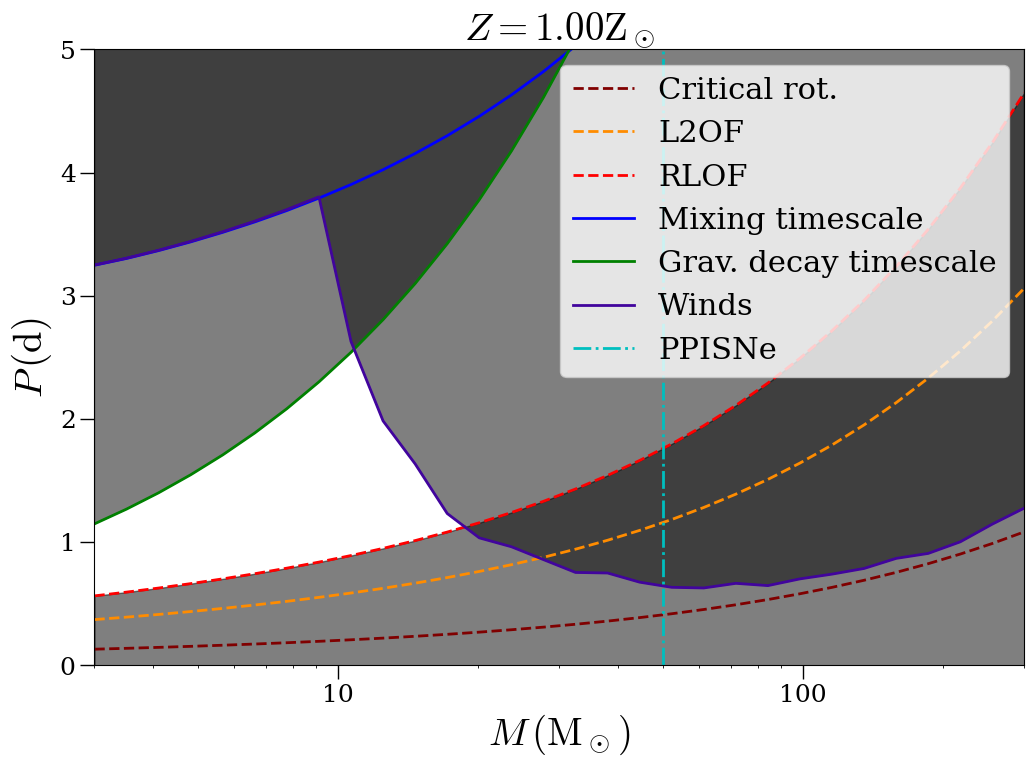

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(test_masses, kepler_test_ps, '--', color='maroon', label='Critical rot.', lw=2)
ax.plot(test_masses, l2of_test_ps, '--', color='darkorange', label='L2OF', lw=2)
ax.plot(test_masses, rlof_test_ps, '--', color='red', label='RLOF', lw=2)

ax.plot(test_masses, t_mix_test_ps, 'b-', label='Mixing timescale', lw=2)
ax.plot(test_masses, t_gw_test_ps, 'g-', label='Grav. decay timescale', lw=2)

ax.plot(test_masses, wind_test_ps, '-', color=cm.plasma(0.1), label='Winds', lw=2)

ax.plot(ppisne_test_masses, ppisne_test_ps, 'c-.', label='PPISNe')

ax.fill_between(test_masses, t_gw_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)
ax.fill_between(test_masses, np.tile(0, test_masses.shape), rlof_test_ps, color='k', alpha=0.5)
ax.fill_between(test_masses, wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.5)

ax.set_xscale('log')
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([1, 10, 100])

ax.set_xlim(m_min, m_max)
ax.set_ylim(0, 5)

ax.set_ylabel('$P\\,(\\mathrm{d})$')
ax.set_xlabel('$M\\,(\\mathrm{M}_\\odot)$')

ax.set_title(f'$Z={test_z/Z_SUN:.2f}\mathrm{{Z}}_\odot$')

ax.legend()

Below we define functions to create this plot automatically, and discuss it with regard to different wind models and metallicities.

## The importance of metallicity when strong winds are present

### Mixed Hurley+Tout wind model.

In [66]:
def mk_che_window_plot_arrs(m_min, m_max, res, test_q, test_z, wind_model, zams_mrr):
    test_masses = np.logspace(np.log10(m_min), np.log10(m_max), res)
    print('\n'.join((f'Computing constraints for {res} masses between {m_min} and {m_max}, '
                     f'with q={test_q}, Z={test_z/Z_SUN} Zsun and wind models ',
                     f'{wind_model} \n')))
    time00 = time()

    print('Computing critical rotation.')
    time0 = time()
    kepler_test_ps = np.zeros(test_masses.shape)
    for i, m in enumerate(test_masses):
        r = zams_mrr.radius(m)
        kepler_test_ps[i] = P_k(m, r).to(u.d).value
    print(f'Done ({time()-time0:.2f} s).\n')

    print('Computing RLOF@ZAMS.')
    time0 = time()
    rlof_test_ps = np.zeros(test_masses.shape)
    for i, m in enumerate(test_masses):
        def f_to_min(p): return np.abs(zams_mrr.radius(m).value - eggleton_rl1_radius(a_from_p(p, m, test_q), test_q).value)
        rlof_test_ps[i] = fmin(f_to_min, x0=1, disp=False)[0]
    print(f'Done ({time()-time0:.2f} s).\n')

    
    print('Computing L2OF@ZAMS.')
    time0 = time()
    l2of_test_ps = np.zeros(test_masses.shape)
    for i, m in enumerate(test_masses):
        def f_to_min(p): return np.abs(zams_mrr.radius(m).value - marchant_l2_radius(a_from_p(p, m, test_q), test_q).value)
        l2of_test_ps[i] = fmin(f_to_min, x0=1, disp=False)[0]
    print(f'Done ({time()-time0:.2f} s).\n')

    print('Computing mixing time.')
    time0 = time()
    t_mix_test_ps = np.zeros(test_masses.shape)
    for i, m in enumerate(test_masses):
        r = zams_mrr.radius(m)
        def f_to_min(p): return np.abs(tau_ms(m, test_z).value - tau_mix(m, r, p, test_q, metallicity=test_z, mode='turbulent').value)
        t_mix_test_ps[i] = fmin(f_to_min, x0=1, disp=False)[0]
    print(f'Done ({time()-time0:.2f} s).\n')

    print('Computing GW timescale.')
    time0 = time()
    t_gw_test_ps = np.zeros(test_masses.shape)
    for i, m in enumerate(test_masses):
        def f_to_min(p): return np.abs(tau_gw(m, p, test_q).value - t_H.value)
        t_gw_test_ps[i] = fmin(f_to_min, x0=1, disp=False)[0]
    print(f'Done ({time()-time0:.2f} s).\n')

    print('Computing PPISNe limit.')
    time0 = time()
    ppisne_test_ps = np.linspace(0, 5, 30)
    ppisne_test_masses = np.zeros(ppisne_test_ps.shape)
    for i, p in enumerate(ppisne_test_ps):
        def f_to_min(m):
            a = a_from_p(p, m, test_q)
            m_tams, a_tams, p_tams, q_tams  = get_tams(m, a_zams=a, q_zams=test_q, mixed_wind_model_dict=wind_model)
            return np.abs(m_tams - 50)
        ppisne_test_masses[i] = fmin(f_to_min, x0=50, disp=False)[0]
    print(f'Done ({time()-time0:.2f} s).\n')

    print('Computing winds.')
    wind_test_ps = np.zeros(test_masses.shape)
    for i, m in enumerate(test_masses):
        def f_to_min(p): 
            a = a_from_p(p, m, test_q)
            m_tams, a_tams, p_tams, q_tams  = get_tams(m, a, test_q, wind_model)
            r_tams = zams_mrr.radius(m)
            return np.abs(tau_ms(m, test_z).value - tau_es(m_tams, r_tams, 2*np.pi/p_tams, test_z).value)
        wind_test_ps[i] = fmin(f_to_min, x0=1, disp=False)[0]
    print(f'Done ({time()-time0:.2f} s).\n')

    print(f'Computed all constraints in {time()-time00:.2f} s.')

    return test_masses, rlof_test_ps, l2of_test_ps, t_mix_test_ps, t_gw_test_ps, wind_test_ps, kepler_test_ps, ppisne_test_ps, ppisne_test_masses

In [67]:
def mk_che_window_plot(ax, che_window_settings, constraint_arrays):
    test_masses, rlof_test_ps, l2of_test_ps, t_mix_test_ps, t_gw_test_ps, wind_test_ps, kepler_test_ps, ppisne_test_ps, ppisne_test_masses = constraint_arrays
    m_min = che_window_settings['m_min']
    m_max = che_window_settings['m_max']
    test_z = che_window_settings['test_z']

    ax.plot(test_masses, rlof_test_ps, '--', color='red', label='RLOF', lw=2)
    ax.plot(test_masses, l2of_test_ps, '--', color='darkorange', label='L2OF', lw=2)
    ax.plot(test_masses, kepler_test_ps, '--', color='maroon', label='Critical rot.', lw=2)

    ax.plot(test_masses, t_mix_test_ps, 'b-', label='Mixing timescale', lw=2)
    ax.plot(test_masses, t_gw_test_ps, 'g-', label='Grav. decay timescale', lw=2)

    ax.plot(test_masses, wind_test_ps, '-', color='m', label='Winds', lw=2)

    ax.plot(ppisne_test_masses, ppisne_test_ps, 'c-.', label='PPISNe')
    
    ax.fill_between(test_masses, t_gw_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.3)
    ax.fill_between(test_masses, np.tile(0.1, test_masses.shape), rlof_test_ps, color='k', alpha=0.3)
    ax.fill_between(test_masses, wind_test_ps, np.tile(10, test_masses.shape), color='k', alpha=0.3)

    ax.text(0.9, 0.9, f'$\mathrm{{Z}}_\odot/{Z_SUN/test_z:.0f}$', ha='right', va='top', transform=ax.transAxes)

In [68]:
test_z = Z_SUN
mix_zsun1_che_window_settings = dict(test_z=test_z,
                                  wind_model=mixed_model_dict(test_z),
                                  zams_mrr=ToutMassRadiusRelation(test_z),
                                  m_min=10.**0.5,
                                  m_max=10.**2.5,
                                  res=30,
                                  test_q=1.)
mix_zsun1_constraints = mk_che_window_plot_arrs(**mix_zsun1_che_window_settings)

Computing constraints for 30 masses between 3.1622776601683795 and 316.22776601683796, with q=1.0, Z=1.0 Zsun and wind models 
{'wind': <__main__.VinkSanderWinds object at 0x155501a3a890>, 'mlr': <__main__.HurleyMassLuminosityRelation object at 0x155501a38970>, 'mrr': <__main__.ToutMassRadiusRelation object at 0x155501a39cf0>, 'metallicity': 0.02} 

Computing critical rotation.
Done (0.01 s).

Computing RLOF@ZAMS.
Done (0.36 s).

Computing L2OF@ZAMS.
Done (0.46 s).

Computing mixing time.
Done (3.19 s).

Computing GW timescale.
Done (1.09 s).

Computing PPISNe limit.


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done (217.78 s).

Computing winds.
Done (393.31 s).

Computed all constraints in 398.41 s.


In [69]:
test_z = Z_SUN/5
mix_zsun_div5_che_window_settings = dict(test_z=test_z,
                                  wind_model=mixed_model_dict(test_z),
                                  zams_mrr=ToutMassRadiusRelation(test_z),
                                  m_min=10.**0.5,
                                  m_max=10.**2.5,
                                  res=30,
                                  test_q=1.)
mix_zsun_div5_constraints = mk_che_window_plot_arrs(**mix_zsun_div5_che_window_settings)

Computing constraints for 30 masses between 3.1622776601683795 and 316.22776601683796, with q=1.0, Z=0.2 Zsun and wind models 
{'wind': <__main__.VinkSanderWinds object at 0x155501a3bcd0>, 'mlr': <__main__.HurleyMassLuminosityRelation object at 0x155501a386a0>, 'mrr': <__main__.ToutMassRadiusRelation object at 0x155501a3a7d0>, 'metallicity': 0.004} 

Computing critical rotation.
Done (0.01 s).

Computing RLOF@ZAMS.
Done (0.30 s).

Computing L2OF@ZAMS.
Done (0.31 s).

Computing mixing time.
Done (2.50 s).

Computing GW timescale.
Done (1.08 s).

Computing PPISNe limit.


Done (138.60 s).

Computing winds.
Done (271.08 s).

Computed all constraints in 275.28 s.


In [70]:
test_z = Z_SUN/10
mix_zsun_div10_che_window_settings = dict(test_z=test_z,
                                  wind_model=mixed_model_dict(test_z),
                                  zams_mrr=ToutMassRadiusRelation(test_z),
                                  m_min=10.**0.5,
                                  m_max=10.**2.5,
                                  res=30,
                                  test_q=1.)
mix_zsun_div10_constraints = mk_che_window_plot_arrs(**mix_zsun_div10_che_window_settings)

Computing constraints for 30 masses between 3.1622776601683795 and 316.22776601683796, with q=1.0, Z=0.1 Zsun and wind models 
{'wind': <__main__.VinkSanderWinds object at 0x155501842650>, 'mlr': <__main__.HurleyMassLuminosityRelation object at 0x155501840ee0>, 'mrr': <__main__.ToutMassRadiusRelation object at 0x1555018ed510>, 'metallicity': 0.002} 

Computing critical rotation.
Done (0.01 s).

Computing RLOF@ZAMS.
Done (0.29 s).

Computing L2OF@ZAMS.
Done (0.33 s).

Computing mixing time.
Done (2.41 s).

Computing GW timescale.
Done (1.09 s).

Computing PPISNe limit.


Done (88.22 s).

Computing winds.
Done (224.07 s).

Computed all constraints in 228.21 s.


In [71]:
test_z = Z_SUN/20
mix_zsun_div20_che_window_settings = dict(test_z=test_z,
                                  wind_model=mixed_model_dict(test_z),
                                  zams_mrr=ToutMassRadiusRelation(test_z),
                                  m_min=10.**0.5,
                                  m_max=10.**2.5,
                                  res=30,
                                  test_q=1.)
mix_zsun_div20_constraints = mk_che_window_plot_arrs(**mix_zsun_div20_che_window_settings)

Computing constraints for 30 masses between 3.1622776601683795 and 316.22776601683796, with q=1.0, Z=0.05 Zsun and wind models 
{'wind': <__main__.VinkSanderWinds object at 0x155500e9b820>, 'mlr': <__main__.HurleyMassLuminosityRelation object at 0x1555018ed1e0>, 'mrr': <__main__.ToutMassRadiusRelation object at 0x1555018ed990>, 'metallicity': 0.001} 

Computing critical rotation.
Done (0.01 s).

Computing RLOF@ZAMS.
Done (0.31 s).

Computing L2OF@ZAMS.
Done (0.33 s).

Computing mixing time.
Done (2.74 s).

Computing GW timescale.
Done (1.51 s).

Computing PPISNe limit.
Done (49.67 s).

Computing winds.
Done (177.03 s).

Computed all constraints in 181.93 s.


### Mixed Hurley+Tout wind model.

In [72]:
test_z = Z_SUN
he_zsun1_che_window_settings = dict(test_z=test_z,
                                  wind_model=he_model_dict(test_z),
                                  zams_mrr=ToutMassRadiusRelation(test_z),
                                  m_min=10.**0.5,
                                  m_max=10.**2.5,
                                  res=30,
                                  test_q=1.)
he_zsun1_constraints = mk_che_window_plot_arrs(**he_zsun1_che_window_settings)

Computing constraints for 30 masses between 3.1622776601683795 and 316.22776601683796, with q=1.0, Z=1.0 Zsun and wind models 
{'wind': <__main__.VinkSanderWinds object at 0x1554ffad9f60>, 'mlr': <__main__.HurleyMassLuminosityRelation object at 0x1554ffa8b1f0>, 'mrr': <__main__.HurleyMassRadiusRelation object at 0x1554ffa8a8f0>, 'metallicity': 0.02} 

Computing critical rotation.
Done (0.01 s).

Computing RLOF@ZAMS.
Done (0.44 s).

Computing L2OF@ZAMS.
Done (0.33 s).

Computing mixing time.


Done (2.88 s).

Computing GW timescale.
Done (1.30 s).

Computing PPISNe limit.
Done (369.20 s).

Computing winds.
Done (571.53 s).

Computed all constraints in 576.49 s.


In [73]:
test_z = Z_SUN/5
he_zsun_div5_che_window_settings = dict(test_z=test_z,
                                  wind_model=he_model_dict(test_z),
                                  zams_mrr=ToutMassRadiusRelation(test_z),
                                  m_min=10.**0.5,
                                  m_max=10.**2.5,
                                  res=30,
                                  test_q=1.)
he_zsun_div5_constraints = mk_che_window_plot_arrs(**he_zsun_div5_che_window_settings)

Computing constraints for 30 masses between 3.1622776601683795 and 316.22776601683796, with q=1.0, Z=0.2 Zsun and wind models 
{'wind': <__main__.VinkSanderWinds object at 0x1555003488e0>, 'mlr': <__main__.HurleyMassLuminosityRelation object at 0x15550034a110>, 'mrr': <__main__.HurleyMassRadiusRelation object at 0x1555004a5510>, 'metallicity': 0.004} 

Computing critical rotation.
Done (0.01 s).

Computing RLOF@ZAMS.
Done (0.30 s).

Computing L2OF@ZAMS.
Done (0.31 s).

Computing mixing time.
Done (2.40 s).

Computing GW timescale.
Done (1.09 s).

Computing PPISNe limit.


Done (281.14 s).

Computing winds.
Done (436.34 s).

Computed all constraints in 440.45 s.


In [74]:
test_z = Z_SUN/10
he_zsun_div10_che_window_settings = dict(test_z=test_z,
                                  wind_model=he_model_dict(test_z),
                                  zams_mrr=ToutMassRadiusRelation(test_z),
                                  m_min=10.**0.5,
                                  m_max=10.**2.5,
                                  res=30,
                                  test_q=1.)
he_zsun_div10_constraints = mk_che_window_plot_arrs(**he_zsun_div10_che_window_settings)

Computing constraints for 30 masses between 3.1622776601683795 and 316.22776601683796, with q=1.0, Z=0.1 Zsun and wind models 
{'wind': <__main__.VinkSanderWinds object at 0x1555003a2f80>, 'mlr': <__main__.HurleyMassLuminosityRelation object at 0x1555003a3d00>, 'mrr': <__main__.HurleyMassRadiusRelation object at 0x1554ff84c3d0>, 'metallicity': 0.002} 

Computing critical rotation.
Done (0.01 s).

Computing RLOF@ZAMS.
Done (0.32 s).

Computing L2OF@ZAMS.
Done (0.32 s).

Computing mixing time.
Done (2.79 s).

Computing GW timescale.
Done (1.38 s).

Computing PPISNe limit.
Done (162.66 s).

Computing winds.
Done (295.08 s).

Computed all constraints in 299.89 s.


In [75]:
test_z = Z_SUN/20
he_zsun_div20_che_window_settings = dict(test_z=test_z,
                                  wind_model=he_model_dict(test_z),
                                  zams_mrr=ToutMassRadiusRelation(test_z),
                                  m_min=10.**0.5,
                                  m_max=10.**2.5,
                                  res=30,
                                  test_q=1.)
he_zsun_div20_constraints = mk_che_window_plot_arrs(**he_zsun_div20_che_window_settings)

Computing constraints for 30 masses between 3.1622776601683795 and 316.22776601683796, with q=1.0, Z=0.05 Zsun and wind models 
{'wind': <__main__.VinkSanderWinds object at 0x155500348a90>, 'mlr': <__main__.HurleyMassLuminosityRelation object at 0x1555003488b0>, 'mrr': <__main__.HurleyMassRadiusRelation object at 0x1555004dcee0>, 'metallicity': 0.001} 

Computing critical rotation.
Done (0.01 s).

Computing RLOF@ZAMS.
Done (0.29 s).

Computing L2OF@ZAMS.
Done (0.33 s).

Computing mixing time.


Done (2.37 s).

Computing GW timescale.
Done (1.10 s).

Computing PPISNe limit.
Done (68.71 s).

Computing winds.
Done (170.05 s).

Computed all constraints in 174.15 s.


### Comparison

Text(0.5, 0.05, '$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

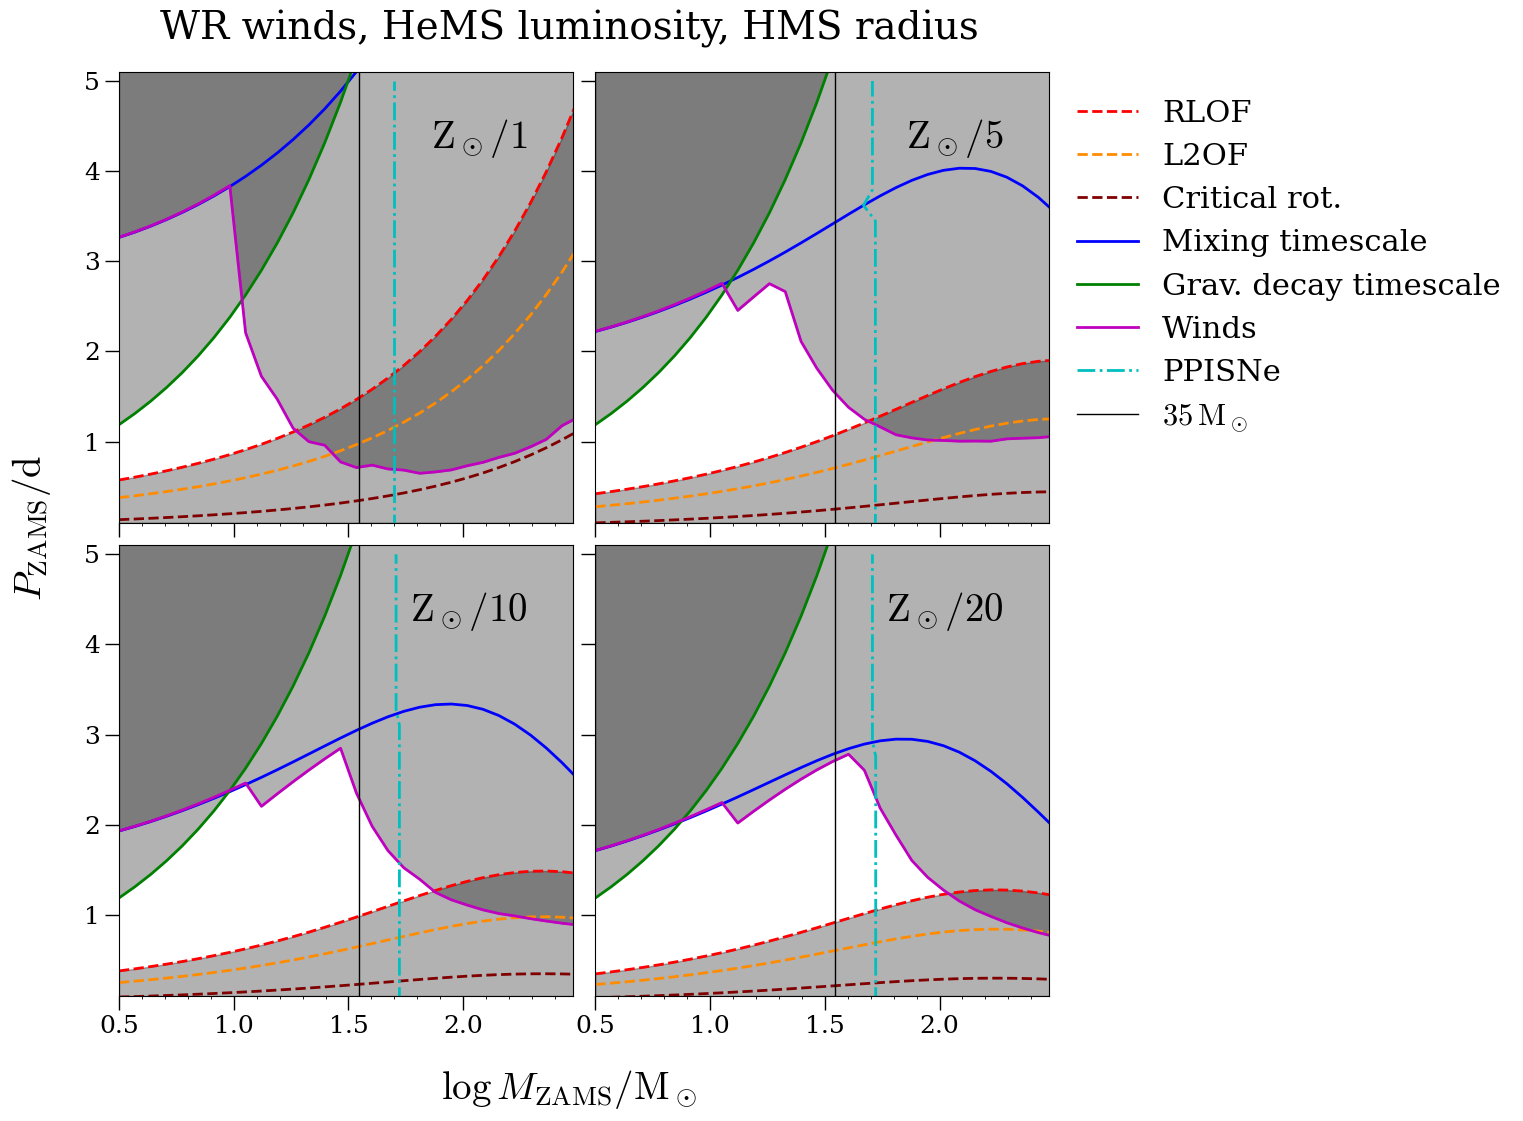

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

mk_che_window_plot(axes[0,0], mix_zsun1_che_window_settings, mix_zsun1_constraints)
mk_che_window_plot(axes[0,1], mix_zsun_div5_che_window_settings, mix_zsun_div5_constraints)
mk_che_window_plot(axes[1,0], mix_zsun_div10_che_window_settings, mix_zsun_div10_constraints)
mk_che_window_plot(axes[1,1], mix_zsun_div20_che_window_settings, mix_zsun_div20_constraints)

handles, labels = axes[0,1].get_legend_handles_labels()
handles.append(Line2D((0, 0), (0, 0), color='k', linewidth=1, label='$35\\,\\mathrm{M}_\\odot$'))
axes[0,1].legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xticks([1, 10, 100])
    ax.set_xticklabels([1, 10, 100])
    ax.set_xlim(m_min, m_max)
    ax.vlines(35, 0, 6, color='k', linewidth=1)

axes[0,0].set_xticks(10.**np.arange(0.5, 2.5, 0.5))
axes[0,0].set_xticklabels(np.arange(0.5, 2.5, 0.5))
axes[0,0].set_xticks(10.**np.arange(0.5, 2.5, 0.1), minor=True)
axes[0,0].set_xticklabels([], minor=True)
axes[0,0].set_ylim(0.1, 5.1)
axes[0,0].set_xlim(10**0.5)

fig.text(0.5, 0.9, 'WR winds, HeMS luminosity, HMS radius', ha='center', va='bottom', transform=fig.transFigure)
fig.text(0.07, 0.5, '$P_\\mathrm{ZAMS}/\\mathrm{d}$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.05, '$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$', ha='center', va='top', transform=fig.transFigure)


Text(0.5, 0.05, '$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

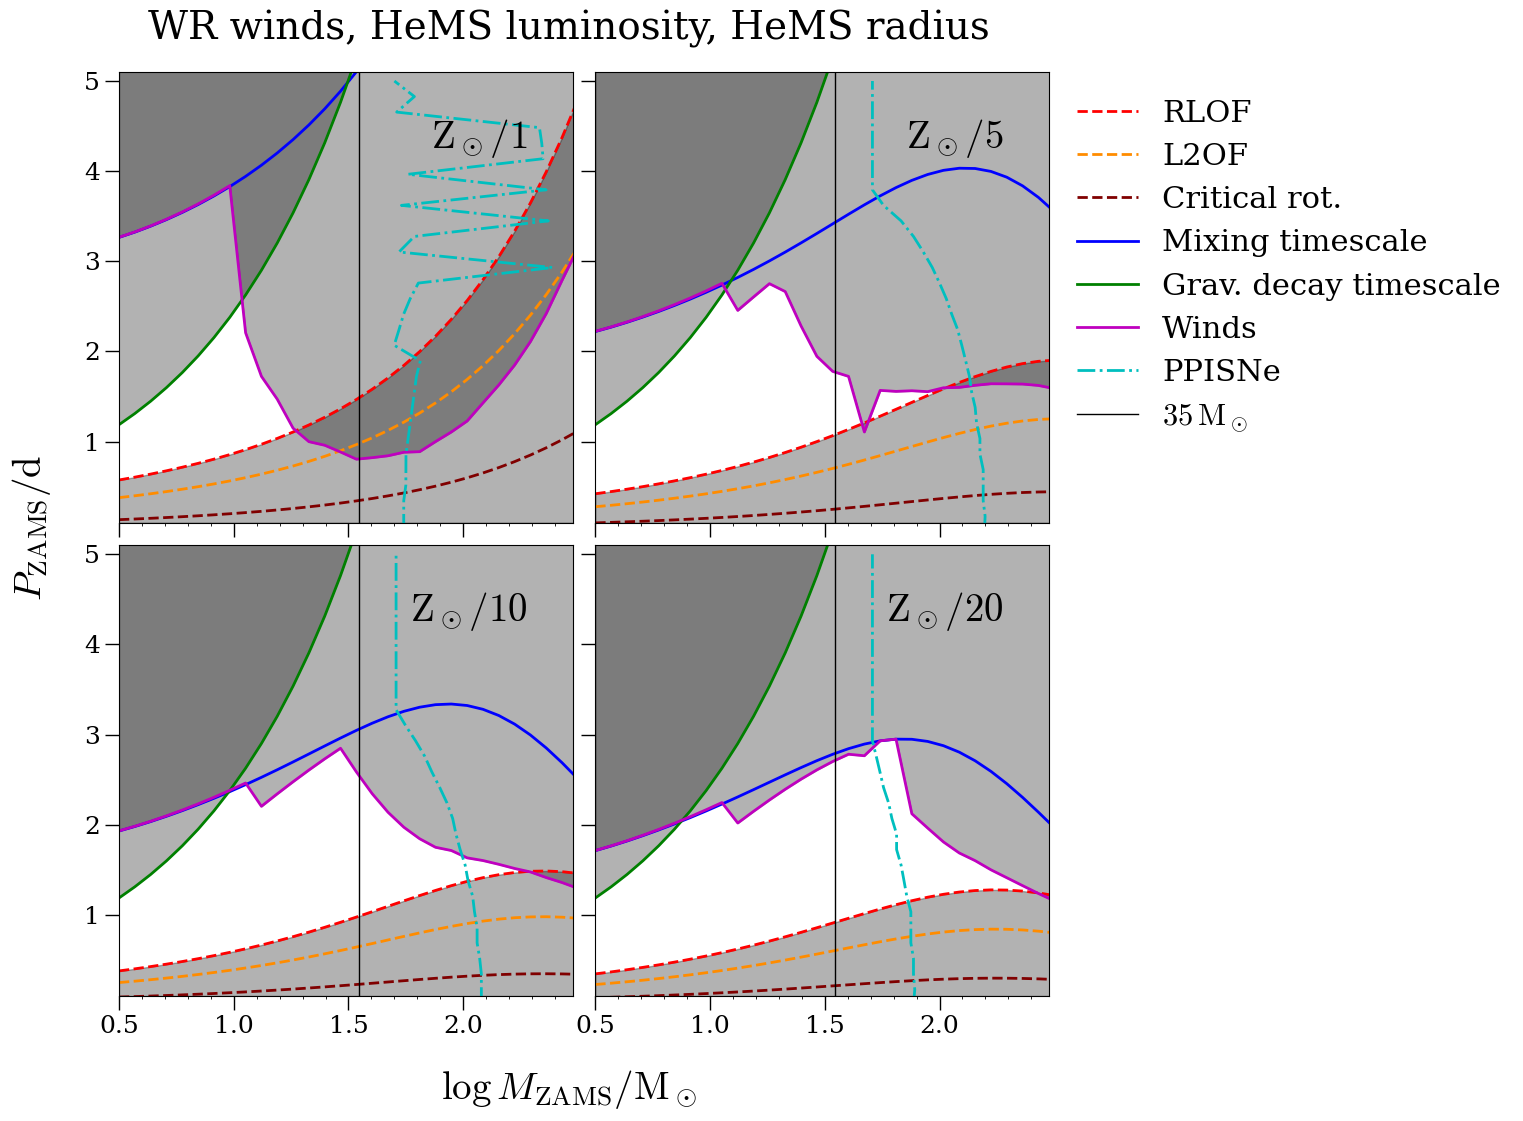

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

mk_che_window_plot(axes[0,0], he_zsun1_che_window_settings, he_zsun1_constraints)
mk_che_window_plot(axes[0,1], he_zsun_div5_che_window_settings, he_zsun_div5_constraints)
mk_che_window_plot(axes[1,0], he_zsun_div10_che_window_settings, he_zsun_div10_constraints)
mk_che_window_plot(axes[1,1], he_zsun_div20_che_window_settings, he_zsun_div20_constraints)

handles, labels = axes[0,1].get_legend_handles_labels()
handles.append(Line2D((0, 0), (0, 0), color='k', linewidth=1, label='$35\\,\\mathrm{M}_\\odot$'))
axes[0,1].legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xticks([1, 10, 100])
    ax.set_xticklabels([1, 10, 100])
    ax.set_xlim(m_min, m_max)
    ax.vlines(35, 0, 6, color='k', linewidth=1)

axes[0,0].set_xticks(10.**np.arange(0.5, 2.5, 0.5))
axes[0,0].set_xticklabels(np.arange(0.5, 2.5, 0.5))
axes[0,0].set_xticks(10.**np.arange(0.5, 2.5, 0.1), minor=True)
axes[0,0].set_xticklabels([], minor=True)
axes[0,0].set_ylim(0.1, 5.1)
axes[0,0].set_xlim(10**0.5)

fig.text(0.5, 0.9, 'WR winds, HeMS luminosity, HeMS radius', ha='center', va='bottom', transform=fig.transFigure)
fig.text(0.07, 0.5, '$P_\\mathrm{ZAMS}/\\mathrm{d}$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.05, '$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$', ha='center', va='top', transform=fig.transFigure)

A few things to note about the behavior of the wind boundary: because mass loss rates are set to $0$ for $L<L_0$ in the WR wind model, some of the less massive stars experience effectively no mass loss. This is because their MS wind mass loss rates are too low to cause any significant orbital widening, and their luminosity is too low to suffer mass loss once they are thorougly mixe and enter the WR regime. The sharp break around $10\,\mathrm{M}$ corresponds to the mass where $L=L_0$ and WR winds are turned on. WR mass loss rates are so high relative to MS that a break is caused; this is also because we implement no smooth transition between MS and WR winds.

## Probability-scaled CHE window

To get a better grasp on how populated the CHE window, we would like to re-scale the plot axes by appropriate probability distributions. For the mass (x) axis, we use a Salpeter IMF,

In [87]:
def mass_forward(m):
    return m**-2.35

def mass_inverse(m):
    return m**(-1/2.35)

For the orbital period (y) axis, we assume a log-uniform ditribution,

In [88]:
def period_forward(p):
    return np.log10(p)

def period_inverse(p):
    return 10.**p

Now for the re-scaled plots,

/tmp/ipykernel_1385995/4269140756.py:2: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p)
/tmp/ipykernel_1385995/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35
/tmp/ipykernel_1385995/1587637377.py:5: RuntimeWarning: invalid value encountered in power
  return m**(-1/2.35)


Text(0.5, 0.05, '$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

/tmp/ipykernel_1385995/4269140756.py:2: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p)
/tmp/ipykernel_1385995/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


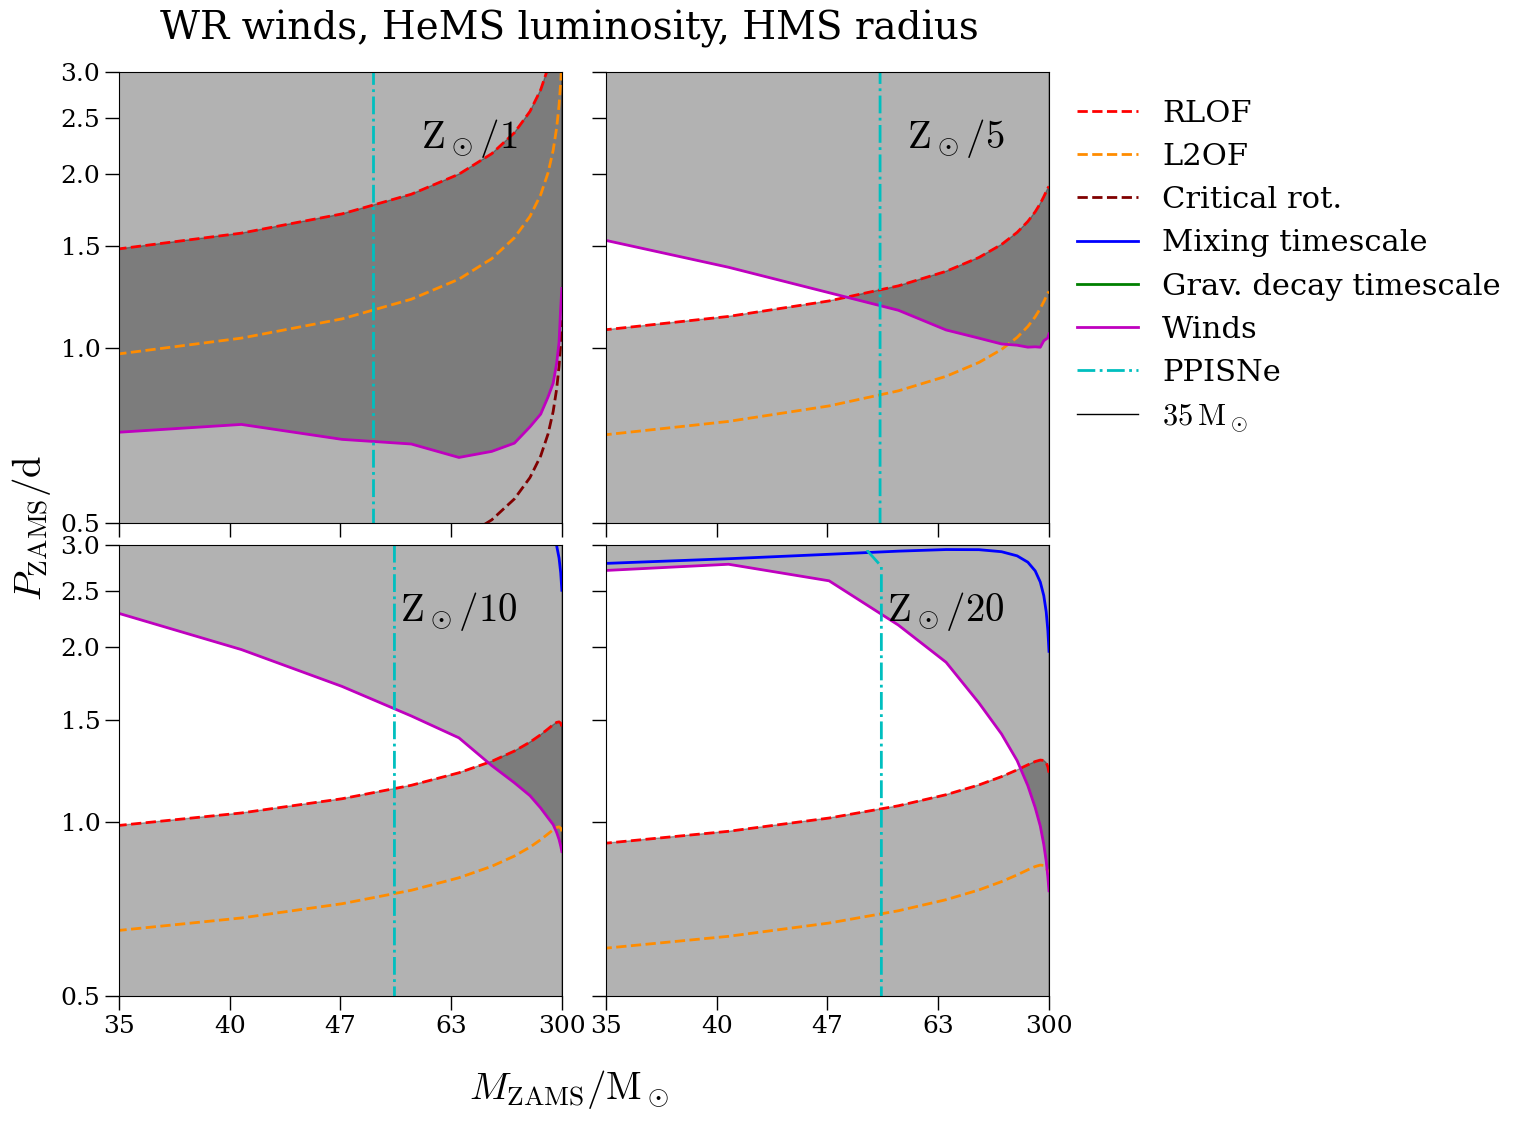

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)

mk_che_window_plot(axes[0,0], mix_zsun1_che_window_settings, mix_zsun1_constraints)
mk_che_window_plot(axes[0,1], mix_zsun_div5_che_window_settings, mix_zsun_div5_constraints)
mk_che_window_plot(axes[1,0], mix_zsun_div10_che_window_settings, mix_zsun_div10_constraints)
mk_che_window_plot(axes[1,1], mix_zsun_div20_che_window_settings, mix_zsun_div20_constraints)

handles, labels = axes[0,1].get_legend_handles_labels()
handles.append(Line2D((0, 0), (0, 0), color='k', linewidth=1, label='$35\\,\\mathrm{M}_\\odot$'))
axes[0,1].legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))

for ax in axes.flatten():
    ax.set_xscale('function', functions=(mass_forward, mass_inverse))
    ax.set_yscale('function', functions=(period_forward, period_inverse))
    ax.vlines(35, 0, 6, color='k', linewidth=1)

xticks = [mass_inverse(x) for x in np.linspace(mass_forward(35), mass_forward(300), 5)]
xticklabels = [f'{x:.0f}' for x in xticks]
axes[0,0].set_xticks(xticks)
axes[0,0].set_xticklabels(xticklabels)

axes[0,0].set_ylim(0.5, 3)
axes[0,0].set_xlim(10**2.5, 35)

fig.text(0.5, 0.9, 'WR winds, HeMS luminosity, HMS radius', ha='center', va='bottom', transform=fig.transFigure)
fig.text(0.07, 0.5, '$P_\\mathrm{ZAMS}/\\mathrm{d}$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.05, '$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$', ha='center', va='top', transform=fig.transFigure)


/tmp/ipykernel_1385995/4269140756.py:2: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p)
/tmp/ipykernel_1385995/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35
/tmp/ipykernel_1385995/1587637377.py:5: RuntimeWarning: invalid value encountered in power
  return m**(-1/2.35)


Text(0.5, 0.05, '$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

/tmp/ipykernel_1385995/4269140756.py:2: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p)
/tmp/ipykernel_1385995/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


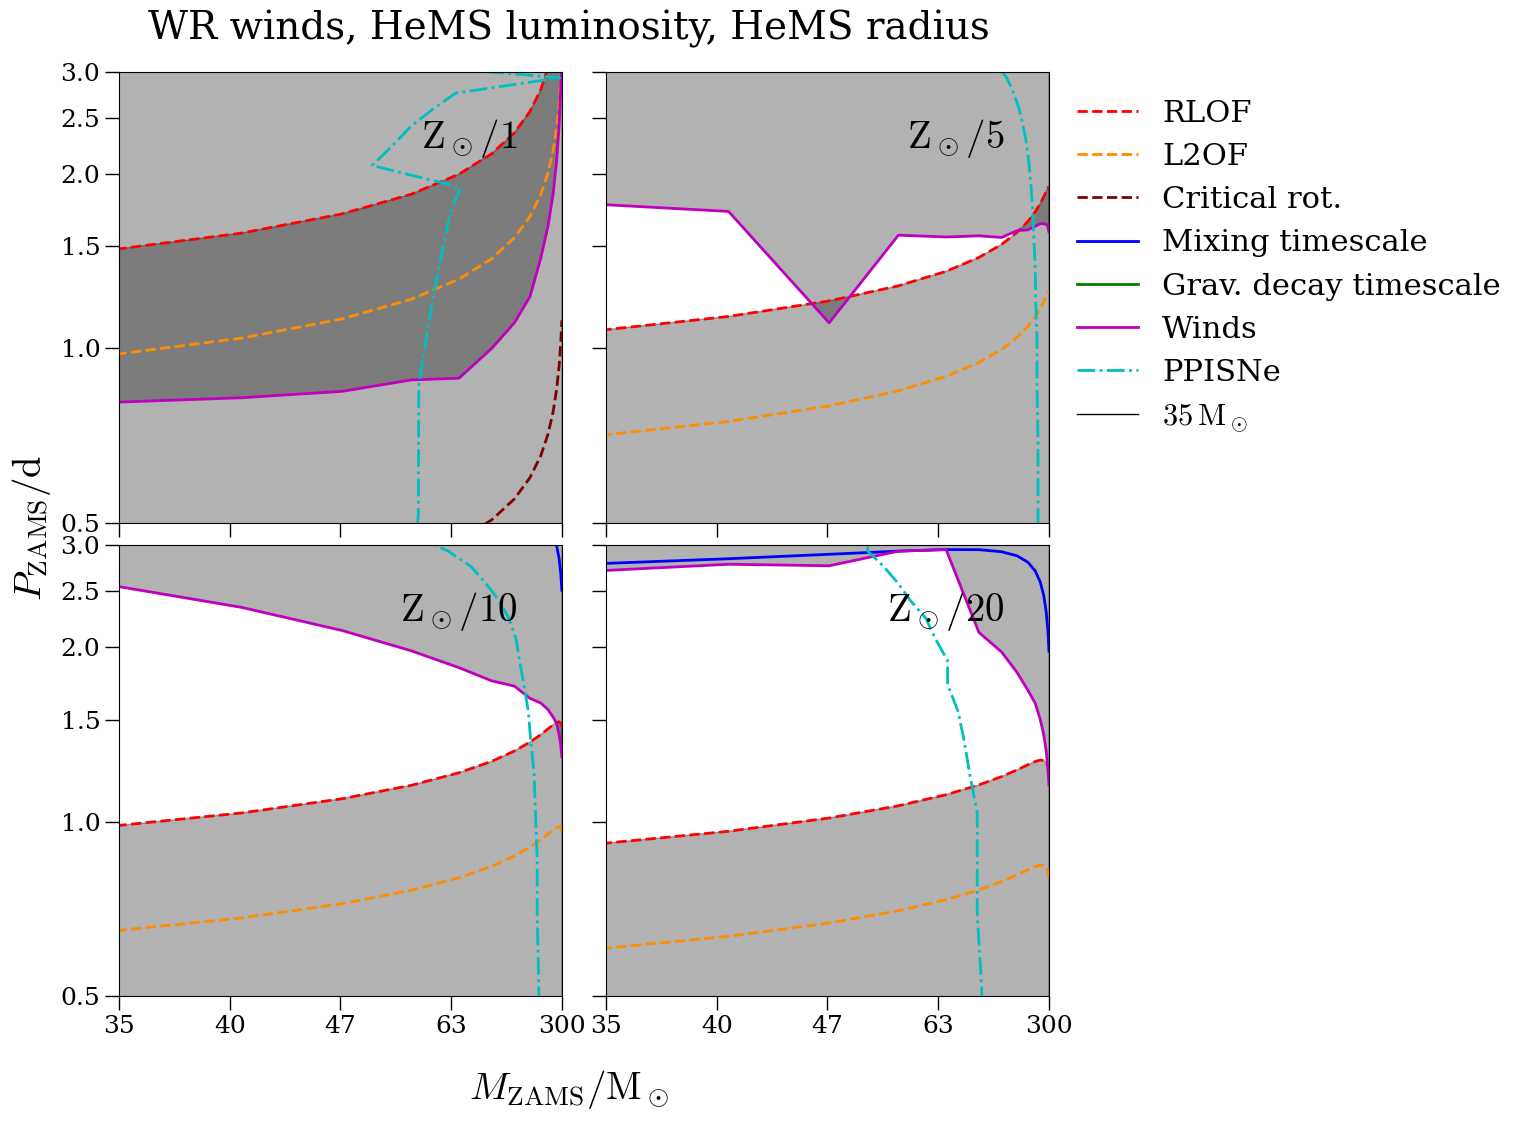

In [90]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)

mk_che_window_plot(axes[0,0], he_zsun1_che_window_settings, he_zsun1_constraints)
mk_che_window_plot(axes[0,1], he_zsun_div5_che_window_settings, he_zsun_div5_constraints)
mk_che_window_plot(axes[1,0], he_zsun_div10_che_window_settings, he_zsun_div10_constraints)
mk_che_window_plot(axes[1,1], he_zsun_div20_che_window_settings, he_zsun_div20_constraints)

handles, labels = axes[0,1].get_legend_handles_labels()
handles.append(Line2D((0, 0), (0, 0), color='k', linewidth=1, label='$35\\,\\mathrm{M}_\\odot$'))
axes[0,1].legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))

for ax in axes.flatten():
    ax.set_xscale('function', functions=(mass_forward, mass_inverse))
    ax.set_yscale('function', functions=(period_forward, period_inverse))
    ax.vlines(35, 0, 6, color='k', linewidth=1)

xticks = [mass_inverse(x) for x in np.linspace(mass_forward(35), mass_forward(300), 5)]
xticklabels = [f'{x:.0f}' for x in xticks]
axes[0,0].set_xticks(xticks)
axes[0,0].set_xticklabels(xticklabels)

axes[0,0].set_ylim(0.5, 3)
axes[0,0].set_xlim(10**2.5, 35)

fig.text(0.5, 0.9, 'WR winds, HeMS luminosity, HeMS radius', ha='center', va='bottom', transform=fig.transFigure)
fig.text(0.07, 0.5, '$P_\\mathrm{ZAMS}/\\mathrm{d}$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.05, '$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$', ha='center', va='top', transform=fig.transFigure)

In all cases, we get no CHE window that could produce $35\,\mathrm{M}_\odot$ at solar metallicity. The window only gradually widens as metallicity continues to drop. Mass at TAMS estimates in the mixed model are unreliable, because winds are so intense that they blow away mass until the star reachs $L_0$ and the winds stop (around $8\,\mathrm{M}_\odot$). In the full HeMS model, winds are more moderate, and this allows for the behavior of the cyan dot-dashed line seen above. Stars to its right always have at least $50\,\mathrm{M}_\odot$ at TAMS and thus fall into the pair-instability trip. However, winds allow some stars over $50\,\mathrm{M}_\odot$ to avoid pair-instability by TAMS, which causes the cyan curve to shift towards high masses.


The shorter the ZAMS orbital period, the quicker the star becomes mixed, the quicker it enters WR-wind regime, and the more mass it loses. This is why the cyan curve is more shifted to the right for shorter perios. The shift is stronger at higher metallicities, where winds are stronger; but at solar metallicity winds are still too strong for the computation to work within a HMS lifetime (10x HeMS lifetime).

We can get an idea by how relatively small the CHE window is by extending the x axis to lower masses.

/tmp/ipykernel_1385995/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35
/tmp/ipykernel_1385995/4269140756.py:2: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p)
/tmp/ipykernel_1385995/1587637377.py:5: RuntimeWarning: invalid value encountered in power
  return m**(-1/2.35)
/tmp/ipykernel_1385995/4269140756.py:2: RuntimeWarning: invalid value encountered in log10
  return np.log10(p)


Text(0.5, 0.05, '$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

/tmp/ipykernel_1385995/4269140756.py:2: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p)
/tmp/ipykernel_1385995/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


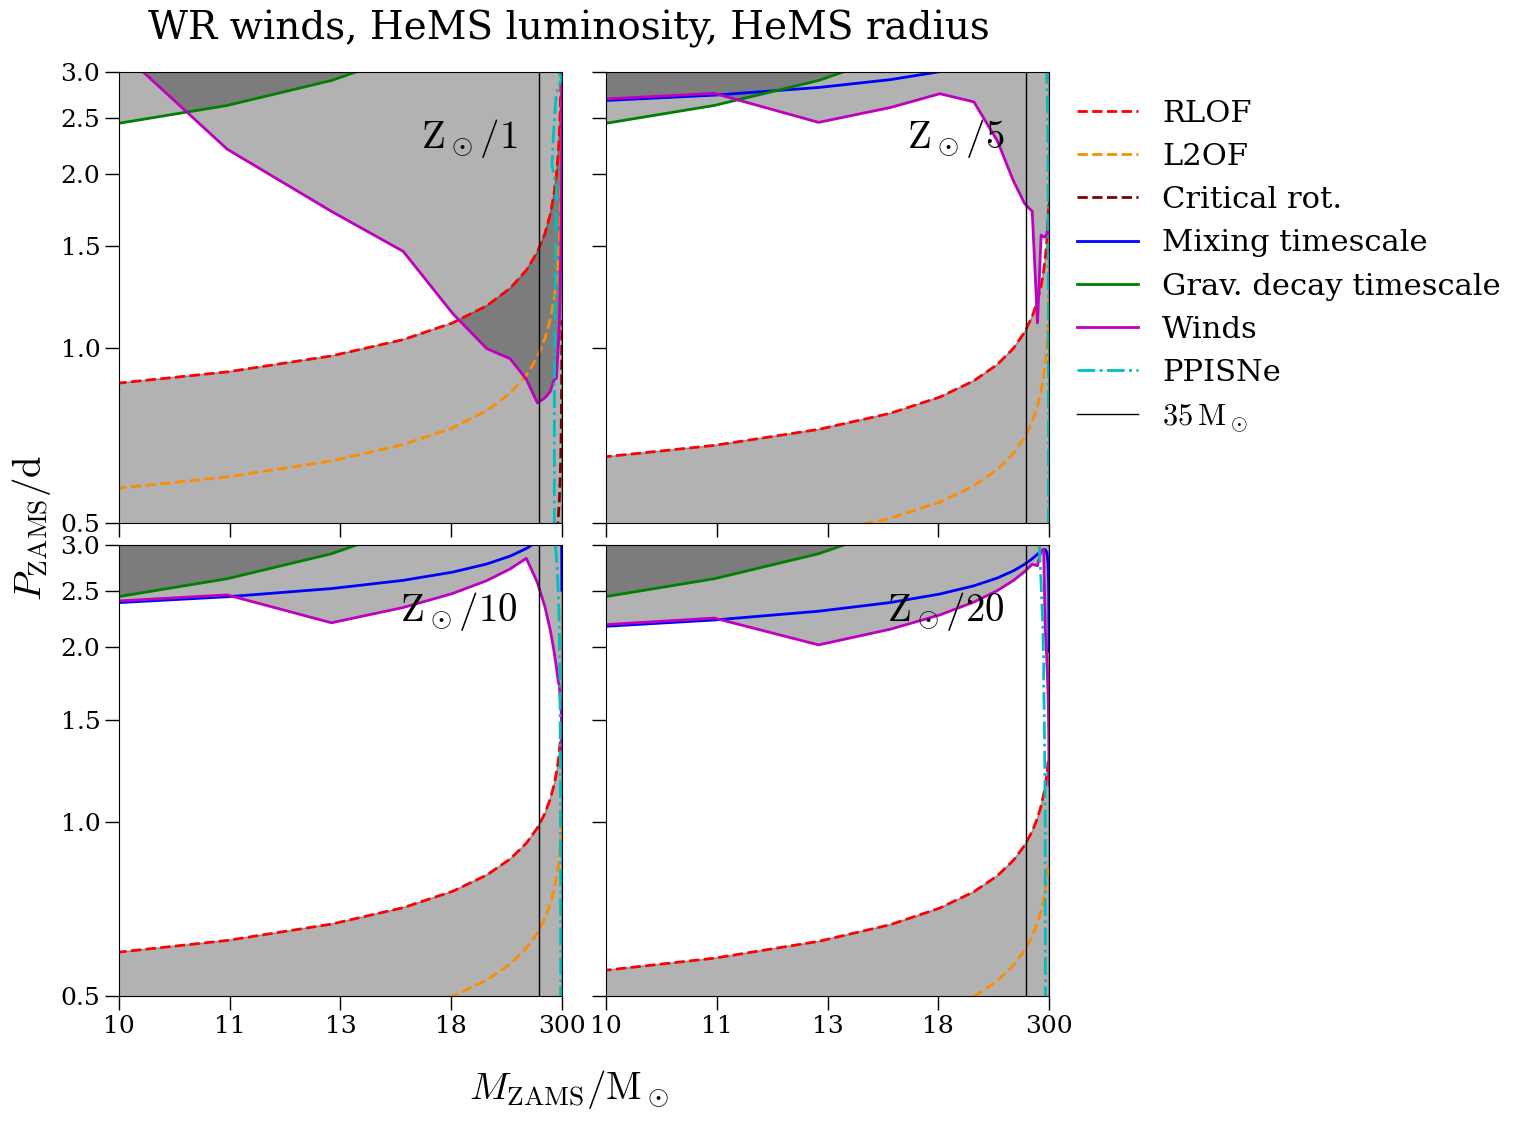

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)

mk_che_window_plot(axes[0,0], he_zsun1_che_window_settings, he_zsun1_constraints)
mk_che_window_plot(axes[0,1], he_zsun_div5_che_window_settings, he_zsun_div5_constraints)
mk_che_window_plot(axes[1,0], he_zsun_div10_che_window_settings, he_zsun_div10_constraints)
mk_che_window_plot(axes[1,1], he_zsun_div20_che_window_settings, he_zsun_div20_constraints)

handles, labels = axes[0,1].get_legend_handles_labels()
handles.append(Line2D((0, 0), (0, 0), color='k', linewidth=1, label='$35\\,\\mathrm{M}_\\odot$'))
axes[0,1].legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))

for ax in axes.flatten():
    ax.set_xscale('function', functions=(mass_forward, mass_inverse))
    ax.set_yscale('function', functions=(period_forward, period_inverse))
    ax.vlines(35, 0.5, 5, color='k', linewidth=1)
    ax.vlines(35, 0, 6, color='k', linewidth=1)

xticks = [mass_inverse(x) for x in np.linspace(mass_forward(10), mass_forward(300), 5)]
xticklabels = [f'{x:.0f}' for x in xticks]
axes[0,0].set_xticks(xticks)
axes[0,0].set_xticklabels(xticklabels)

axes[0,0].set_ylim(0.5, 3)
axes[0,0].set_xlim(10**2.5, 10)

fig.text(0.5, 0.9, 'WR winds, HeMS luminosity, HeMS radius', ha='center', va='bottom', transform=fig.transFigure)
fig.text(0.07, 0.5, '$P_\\mathrm{ZAMS}/\\mathrm{d}$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.05, '$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$', ha='center', va='top', transform=fig.transFigure)

/tmp/ipykernel_1385995/4269140756.py:2: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p)
/tmp/ipykernel_1385995/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35
/tmp/ipykernel_1385995/1587637377.py:5: RuntimeWarning: invalid value encountered in power
  return m**(-1/2.35)


Text(0.5, 0.05, '$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

/tmp/ipykernel_1385995/4269140756.py:2: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p)
/tmp/ipykernel_1385995/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


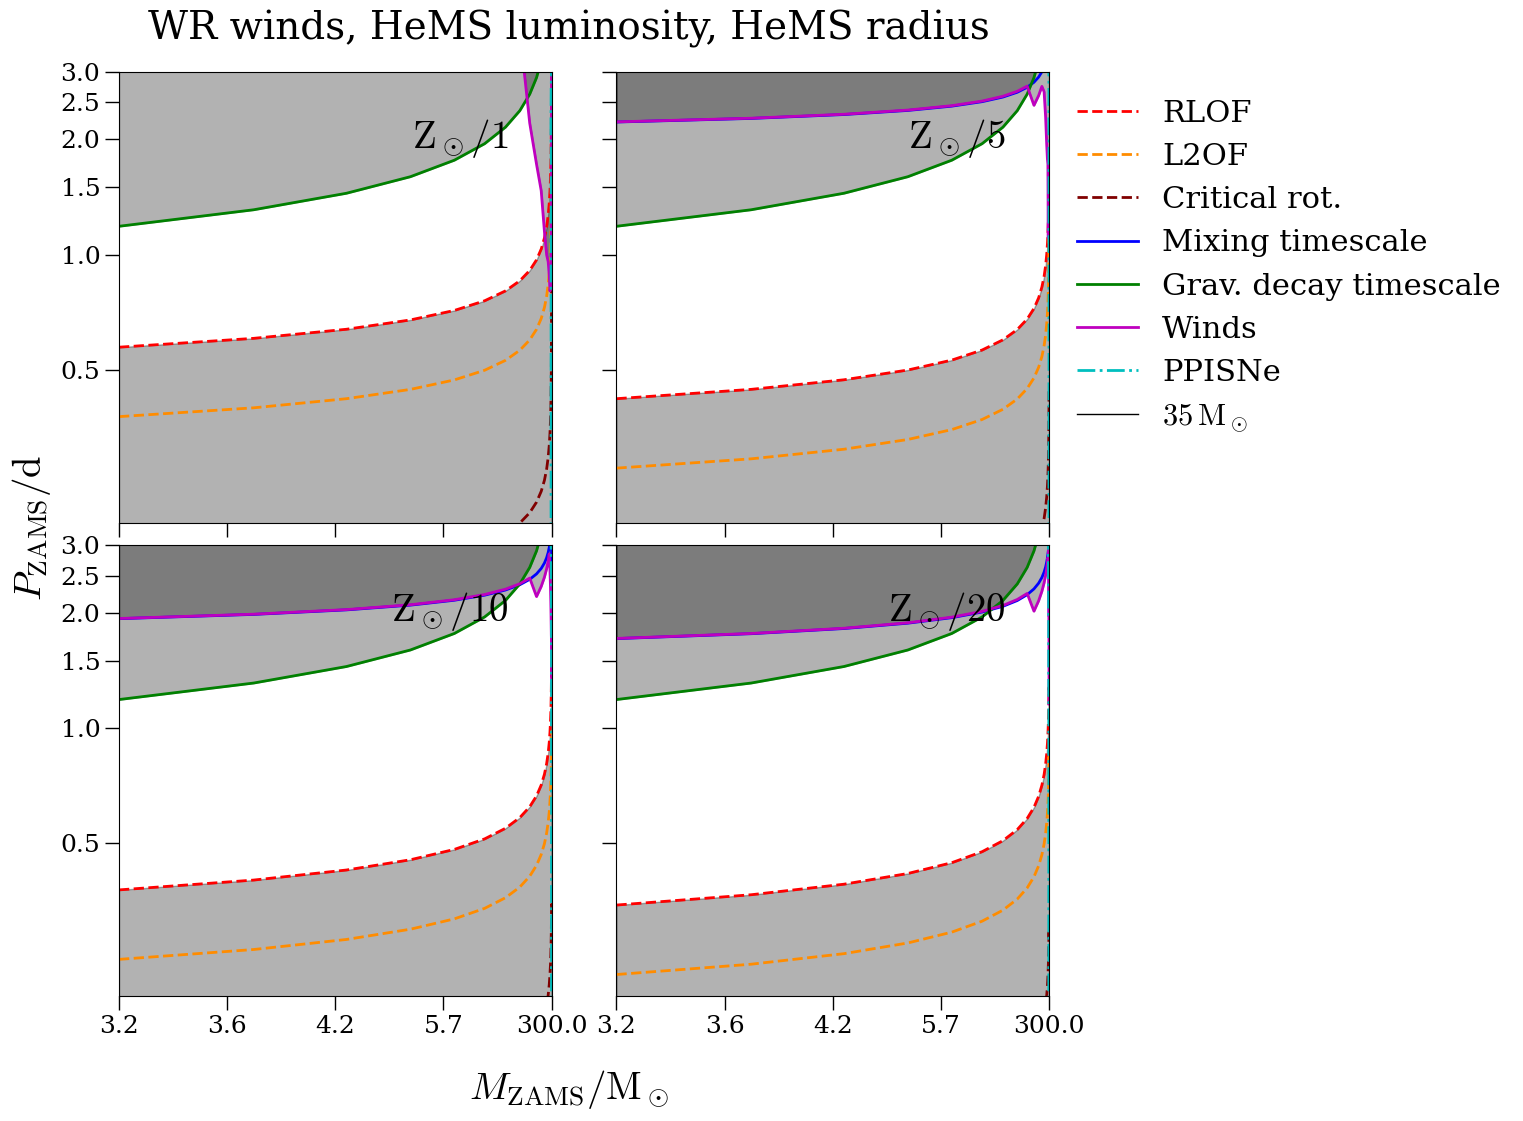

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.15, hspace=0.05)

mk_che_window_plot(axes[0,0], he_zsun1_che_window_settings, he_zsun1_constraints)
mk_che_window_plot(axes[0,1], he_zsun_div5_che_window_settings, he_zsun_div5_constraints)
mk_che_window_plot(axes[1,0], he_zsun_div10_che_window_settings, he_zsun_div10_constraints)
mk_che_window_plot(axes[1,1], he_zsun_div20_che_window_settings, he_zsun_div20_constraints)

handles, labels = axes[0,1].get_legend_handles_labels()
handles.append(Line2D((0, 0), (0, 0), color='k', linewidth=1, label='$35\\,\\mathrm{M}_\\odot$'))
axes[0,1].legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))

for ax in axes.flatten():
    ax.set_xscale('function', functions=(mass_forward, mass_inverse))
    ax.set_yscale('function', functions=(period_forward, period_inverse))
    ax.vlines(35, 0, 6, color='k', linewidth=1)

xticks = [mass_inverse(x) for x in np.linspace(mass_forward(10**0.5), mass_forward(300), 5)]
xticklabels = [f'{x:.1f}' for x in xticks]
axes[0,0].set_xticks(xticks)
axes[0,0].set_xticklabels(xticklabels)

axes[0,0].set_ylim(0.2, 3)
axes[0,0].set_xlim(10**2.5, 10**0.5)

fig.text(0.5, 0.9, 'WR winds, HeMS luminosity, HeMS radius', ha='center', va='bottom', transform=fig.transFigure)
fig.text(0.07, 0.5, '$P_\\mathrm{ZAMS}/\\mathrm{d}$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.05, '$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$', ha='center', va='top', transform=fig.transFigure)

### Saving plot data

In [93]:
import pickle as pkl

In [102]:
pkl.dump(mix_zsun1_che_window_settings, open('./che_window_plot_data/mix_zsun1_che_window_settings.pkl', 'wb'))
pkl.dump(mix_zsun_div5_che_window_settings, open('./che_window_plot_data/mix_zsun_div5_che_window_settings.pkl', 'wb'))
pkl.dump(mix_zsun_div10_che_window_settings, open('./che_window_plot_data/mix_zsun_div10_che_window_settings.pkl', 'wb'))
pkl.dump(mix_zsun_div20_che_window_settings, open('./che_window_plot_data/mix_zsun_div20_che_window_settings.pkl', 'wb'))

pkl.dump(he_zsun1_che_window_settings, open('./che_window_plot_data/he_zsun1_che_window_settings.pkl', 'wb'))
pkl.dump(he_zsun_div5_che_window_settings, open('./che_window_plot_data/he_zsun_div5_che_window_settings.pkl', 'wb'))
pkl.dump(he_zsun_div10_che_window_settings, open('./che_window_plot_data/he_zsun_div10_che_window_settings.pkl', 'wb'))
pkl.dump(he_zsun_div20_che_window_settings, open('./che_window_plot_data/he_zsun_div20_che_window_settings.pkl', 'wb'))

pkl.dump(mix_zsun1_constraints, open('./che_window_plot_data/mix_zsun1_constraints.pkl', 'wb'))
pkl.dump(mix_zsun_div5_constraints, open('./che_window_plot_data/mix_zsun_div5_constraints.pkl', 'wb'))
pkl.dump(mix_zsun_div10_constraints, open('./che_window_plot_data/mix_zsun_div10_constraints.pkl', 'wb'))
pkl.dump(mix_zsun_div20_constraints, open('./che_window_plot_data/mix_zsun_div20_constraints.pkl', 'wb'))

pkl.dump(he_zsun1_constraints, open('./che_window_plot_data/he_zsun1_constraints.pkl', 'wb'))
pkl.dump(he_zsun_div5_constraints, open('./che_window_plot_data/he_zsun_div5_constraints.pkl', 'wb'))
pkl.dump(he_zsun_div10_constraints, open('./che_window_plot_data/he_zsun_div10_constraints.pkl', 'wb'))
pkl.dump(he_zsun_div20_constraints, open('./che_window_plot_data/he_zsun_div20_constraints.pkl', 'wb'))